# Part 1. Import relevant packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, auc, roc_curve, roc_auc_score, precision_recall_fscore_support, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

HOME = "/content/drive/My Drive" # use "/content/drive/My Drive" if you are using Google Colab
HOME = "."

# Part 2: Import raw data on fraud vs. not fraud in self-checkouts

## 2.1 Import the training data, test data, and test data target variable sets

In [ ]:
# Mount to google drive
if HOME == "/content/drive/My Drive":
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
train = pd.read_csv(f"{HOME}/data/train.csv", delimiter="|")
test = pd.read_csv(f"{HOME}/data/test.csv", delimiter="|")
answers = pd.read_csv(f"{HOME}/data/DMC-2019-realclass.csv")

print("training data shape: ", train.shape)
print("test data shape: ", test.shape)
print("answers data shape: ", answers.shape)

training data shape:  (1879, 10)
test data shape:  (498121, 9)
answers data shape:  (498121, 1)


The project requirement is that the data size is at least 50k rows. However, the original training data has only 1879 rows whereas the test data has 498121 rows. After discussing with our project TA Peter, we decided to combine the train and test sets to create full dataset, then we took a sample of 50K rows as the new train set and the remaining 450K rows as the train set.

Note: This section is all commented out so we don't accidentally re-run.

## 2.2 Extract the target variable fraud from the answers dataset and add it to the test set

In [ ]:
# test['fraud'] = answers['fraud']

## 2.3 Concatenate the train and test set to get a full dataset of 500K.(full_set) and reset the index

In [ ]:
# full_data = pd.concat([train, test], axis=0)
# full_data.reset_index(drop=True, inplace=True)

## 2.4 Perform train-test split to get 50K rows for new train set and 450K rows for the test set

In [ ]:
# # Use test_size = 0.9 to get 50k rows in train and 450k in test
# new_train, new_test = train_test_split(full_data, test_size=0.9, random_state=42)
# print("new training data shape: ", new_train.shape)
# print("new test data shape: ", new_test.shape)

As expected, we get 50K rows for our train set and 450K rows for test set.

## 2.5 Save the sampled train-test splits to new csv files to avoid repeating the process

In [ ]:
# # We name the test data as "heldout data" to avoid confusion
# new_train.to_csv("/content/drive/My Drive/data/train_data.csv", index=False)
# new_test.to_csv("/content/drive/My Drive/data/heldout_data.csv", index=False)

# Part 3: Exploratory Data Analysis

As a way to save costs on cashiers, department stores and grocery stores are increasingly adopting self-checkout machines. While these systems offer convenience and efficiency, they also introduce new vulnerabilities. Unlike traditional checkout lanes supervised by employees, self-checkout systems rely heavily on customer honesty and minimal monitoring. This creates opportunities for fraudulent activities, such as intentionally omitting scanning items, voiding high-value products after scanning, or exploiting scanner malfunctions.

This project aims to develop a robust machine learning solution to predict self-checkout fraud based on transaction data. The attributes are shown below. After we take a closer look at the data, we will decide on what metrics to optimize our model for.

| Column Name                   | Description                                                         |
|-------------------------------|---------------------------------------------------------------------|
| trustLevel                    | A customer’s individual trust level                                 |
| totalScanTimeInSeconds        | Total time in seconds between the first and last product scanned    |
| grandTotal                    | Grand total of products scanned                                    |
| lineItemVoids                 | Number of voided scans                                             |
| scansWithoutRegistration      | Number of attempts to activate the scanner without scanning        |
| quantityModification          | Number of modified quantities for scanned products                |
| scannedLineItemsPerSecond     | Average number of scanned products per second                      |
| valuePerSecond                | Average total value of scanned products per second                 |
| lineItemVoidsPerPosition      | Average number of item voids per total scanned (not cancelled)     |
| fraud                         | Classification as fraud or not fraud (target variable)             |



In [ ]:
#df = pd.read_csv(f"{HOME}/data/train_data.csv") # if using colab
df = pd.read_csv("data/train_data.csv")
df.head()

trustLevel  totalScanTimeInSeconds  grandTotal  lineItemVoids  \
0           3                     144       21.70              5   
1           6                     867       56.53              0   
2           2                     266       26.70              8   
3           6                     647        4.29              2   
4           5                     280       45.01             10   

   scansWithoutRegistration  quantityModifications  scannedLineItemsPerSecond  \
0                         2                      1                   0.118056   
1                         5                      2                   0.008074   
2                         0                      4                   0.071429   
3                         9                      5                   0.003091   
4                         5                      3                   0.021429   

   valuePerSecond  lineItemVoidsPerPosition  fraud  
0        0.150694                  0.294118      0  
1        0.065202                  0.000000      0  
2        0.100376                  0.421053      0  
3        0.006631                  1.000000      0  
4        0.160750                  1.666667      0

## 3.1 Check train data for null values and data types

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   trustLevel                 50000 non-null  int64  
 1   totalScanTimeInSeconds     50000 non-null  int64  
 2   grandTotal                 50000 non-null  float64
 3   lineItemVoids              50000 non-null  int64  
 4   scansWithoutRegistration   50000 non-null  int64  
 5   quantityModifications      50000 non-null  int64  
 6   scannedLineItemsPerSecond  50000 non-null  float64
 7   valuePerSecond             50000 non-null  float64
 8   lineItemVoidsPerPosition   50000 non-null  float64
 9   fraud                      50000 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 3.8 MB


1.   Our data has no missing values!
2.   All the features are already numerical, so there's no need for encoding.

## 3.2 Examine the distribution of the target class (fraud) and feature variables

In [ ]:
X = df.drop('fraud', axis=1)
y = df['fraud']

### 3.2a Distribution of fraud vs. not fraud in self-checkouts

There are 2332 frauds out of 50000 transactions
Fraud rate: 4.6640%


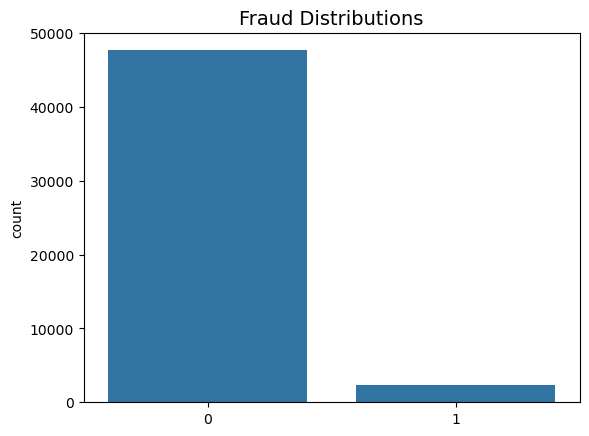

In [ ]:
plt.figure()
sns.countplot(x = y.values);
plt.title('Fraud Distributions', fontsize=14)
print(f"There are {y.sum()} frauds out of {df.shape[0]} transactions")
print(f"Fraud rate: {y.sum() / df.shape[0] * 100:.4f}%")

We have very strong class imbalance! Less than 5% of our data is fraud. Therefore, to ensure meaningful evaluation, we will use the following metrics to evaluate our model:
1. Precision:
   - Measures the proportion of transactions classified as fraud that are actually fraudulent.
   - Higher precision means less false accusations, which improves costumer experience.
2. Recall (or True Positive Rate (TPR)):
   - Measures the proportion of actual fraud that are classified as fraud .
   - Higher recall means more fraudulent transactions are detected, which is critical for reducing financial loss due to undetected fraud.
3. F1-score:
   - F1-score is the harmonic mean of precision and recall.
   - It balances the trade-off between precision and recall. It provides a single metric to evaluate the model’s ability to correctly classify fraud without heavily favoring either precision or recall.
4. ROC-AUC:
   - It measures the area under the TPR vs. FPR curve, which evaluates the model’s ability to distinguish between fraudulent and non-fraudulent transactions across different classification thresholds.
   - It provides an overall measure of the model’s discriminatory power, especially useful in imbalanced datasets.


### 3.2b Distribution of the feature variables

Distribution of features


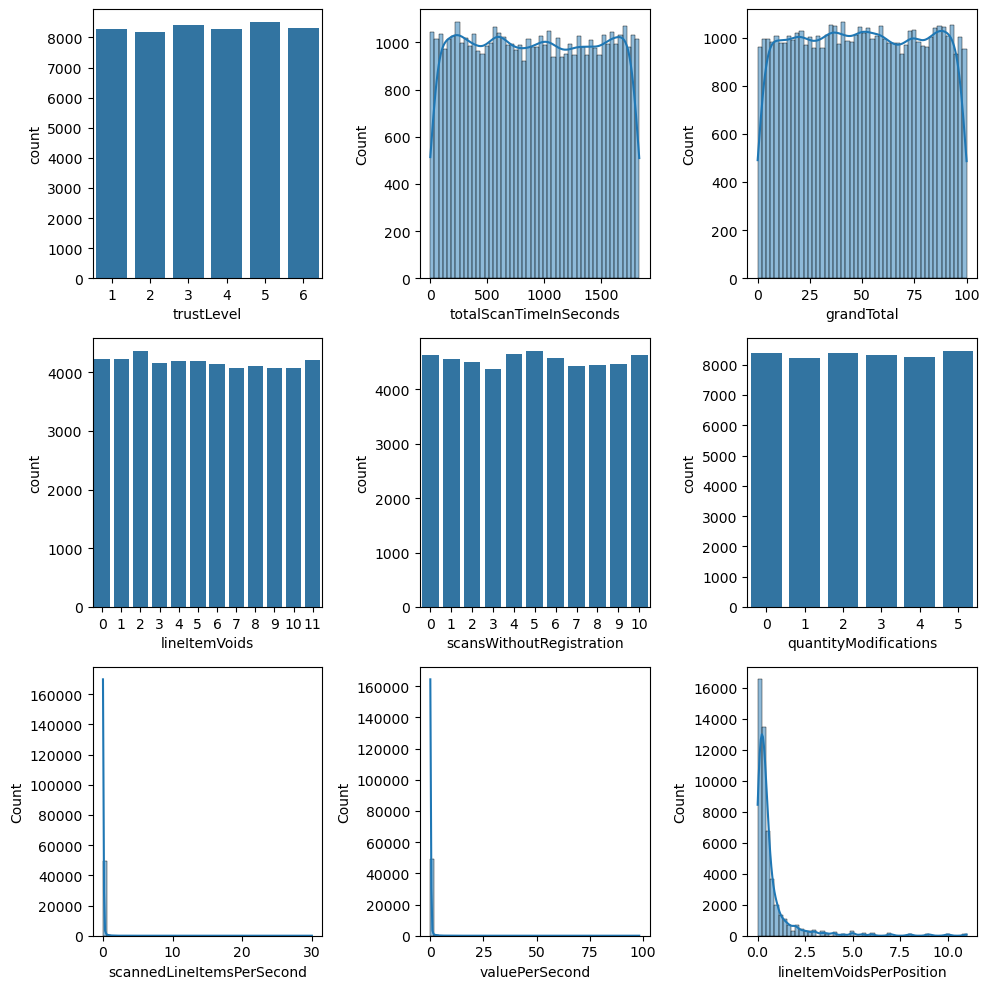

In [ ]:
# Plot distribution of features
int_cols = ['trustLevel', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications']

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax = ax.flatten()
for i, col in enumerate(X.columns):
    if col in int_cols:
        sns.countplot(x=X[col], ax=ax[i])
    else:
        sns.histplot(x=X[col], ax=ax[i], kde=True, bins=50)
fig.tight_layout()
print("Distribution of features")

Other than `scannedLineItemsPerSecond`, `valuePerSecond`, and `lineItemVoidsPerPosition`, all other features are uniformly distributed. These 3 features are heavily right skewed. Let's take a closer look one by one. For each of these features, we will create a boxplot, which will help us to identify the outliers better than a histogram.

#### 3.2bi Further analysis of `scannedLineItemsPerSecond`

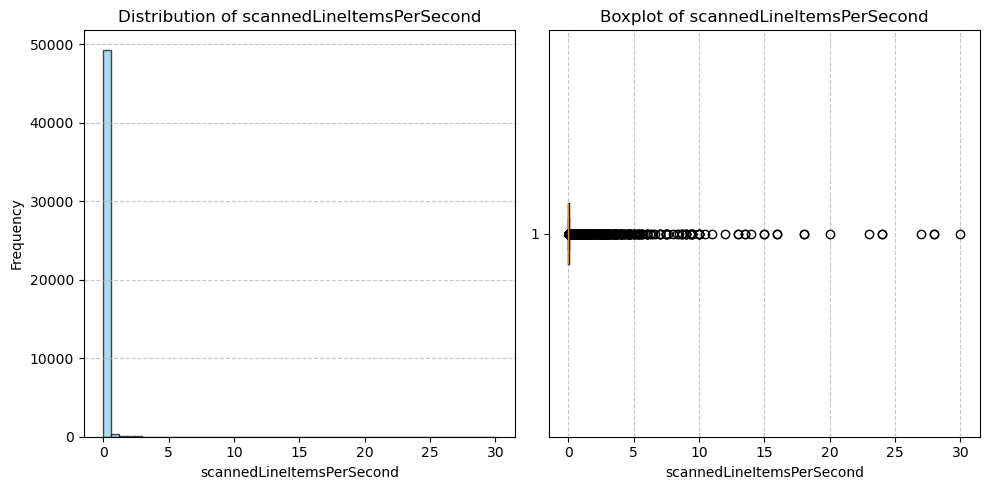

In [ ]:
# Plot detailed histograms and boxplots for the specified features
features_to_examine = ["scannedLineItemsPerSecond", "valuePerSecond", "lineItemVoidsPerPosition"]

def plot_feature_dist(feature, X = X):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(X[feature], bins=50, edgecolor='k', alpha=0.7, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(X[feature], vert=False, patch_artist=True)
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_feature_dist(features_to_examine[0])

`scannedLineItemsPerSecond` is the average number of scanned products per second. Anything above 3, which means scanning more than 3 items/second, seems unreasonably fast. Could it be that this is batch processing (scaning multiple identical items at once)? Let's take a look at the corresponding total scanning time for these rows. We will do so with a scatter plot of `totalScanTimeInSeconds` vs `scannedLineItemsPerSecond`. A scatter plot will allow us to see if there are any patterns in the data.

Number of transactions with scanning speed > 3 items/s: 133


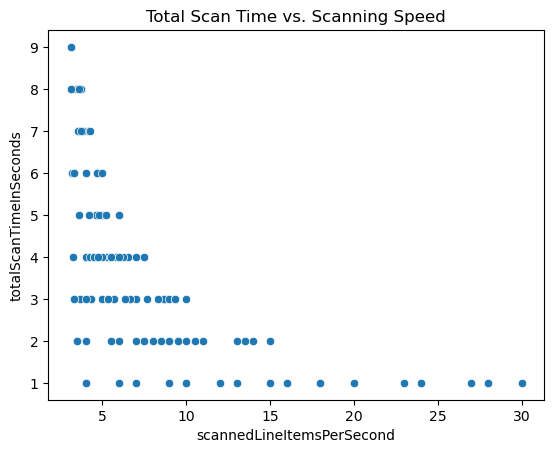

In [ ]:
very_fast_scans = X["scannedLineItemsPerSecond"] > 3
print(f"Number of transactions with scanning speed > 3 items/s: {very_fast_scans.sum()}")
fast_scan_num_items = X[very_fast_scans]["scannedLineItemsPerSecond"]
fast_scan_time = X[very_fast_scans]["totalScanTimeInSeconds"]
sns.scatterplot(x=fast_scan_num_items, y=fast_scan_time)
plt.title("Total Scan Time vs. Scanning Speed");

The above scatter plot shows that many high-speed transactions (e.g., >10 scanned items per second) are associated with very low scan times (e.g., 1–2 seconds). This supports our speculation that the high speed scans are due to batch scanning.

Therefore, the feature `scannedLineItemsPerSecond` may be misleading and not very informative.

We create a new feature `totalItems`, which is the total number of items scanned in a transaction, by mutiplying `scannedLineItemsPerSecond` and `totalScanTimeInSeconds`

##### Visualize new variable `totalItems`

In [ ]:
# Total Number of Items: Derived from scannedLineItemsPerSecond * totalScanTimeInSeconds
X['totalItems'] = (X['scannedLineItemsPerSecond'] * X['totalScanTimeInSeconds']).astype(int)

Let's now see the distributions of the `totalItems`

---





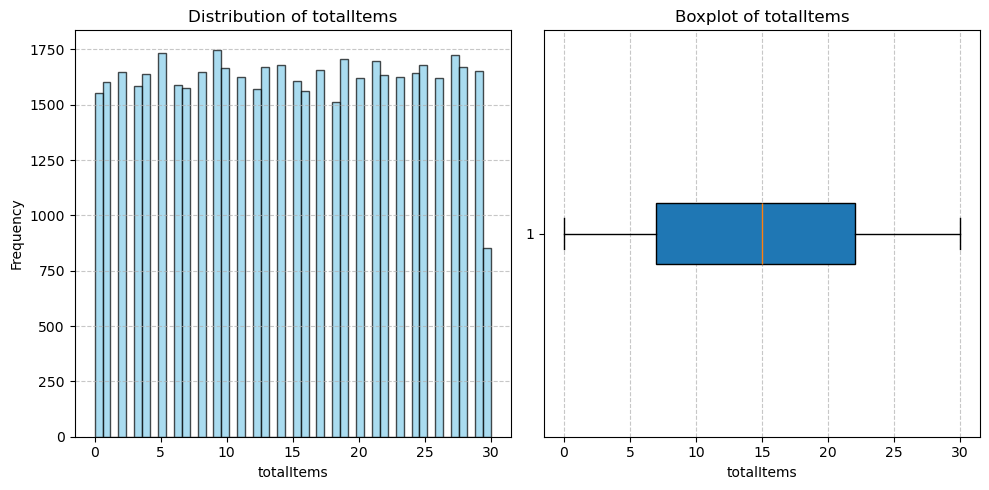

In [ ]:
plot_feature_dist('totalItems')

`totalItems` shows a nice uniform distribution, although with relatively low value at ~30

For proceeding visualization, we also log transform `scannedLineItemsPerSecond` for better clarity.

##### Visualize new variable `logScannedLineItemsPerSecond`:



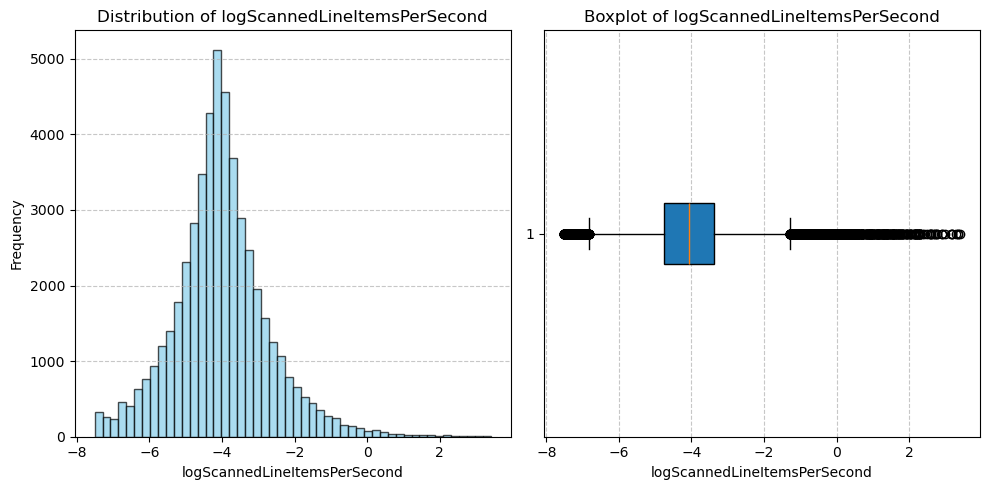

In [ ]:
X['logScannedLineItemsPerSecond'] = np.log(X['scannedLineItemsPerSecond'])
plot_feature_dist('logScannedLineItemsPerSecond')

#### 3.2bii Further analysis of `valuePerSecond`

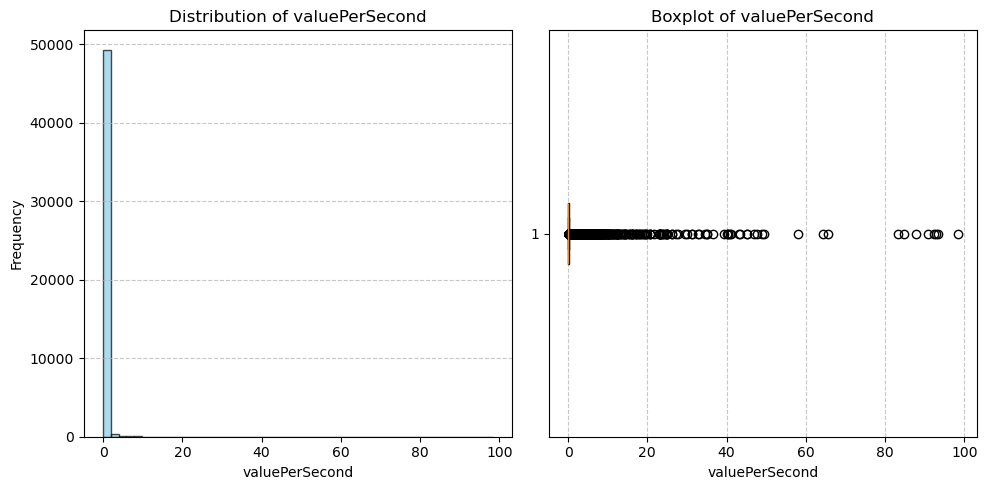

In [ ]:
plot_feature_dist(features_to_examine[1])

`valuePerSecond` is the average total value of scanned products per second. Intuitively, this feature is dependent on the average unit price of the items in a transction, and scanning speed. The former is not given, but in most places with self-checkout like Target and Walmart, they have much more lower priced items than higher priced items. Therefore, we can reasonably assume that the average price per item is right skewed. Furthermore, we previously explained that there exist batch scans, which can scan up to 30 items per second, which can cause high valuePerSecond. We will support this point with the following paired boxplot, which clearly shows that transctions with fast scans has much higher valuePerSecond than slow scans.

##### Visualize distribution of valuePerSecond for slow (false) vs fast (true) scans

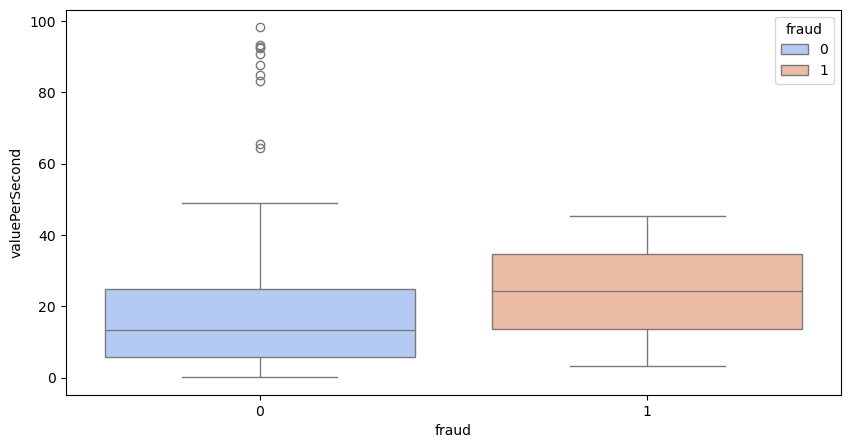

In [ ]:
# Visualize distribution of valuePerSecond for slow (false) vs fast (true) scans
fast_scan_valuePerSecond = X[very_fast_scans]["valuePerSecond"]
slow_scan_valuePerSecond = X[~very_fast_scans]["valuePerSecond"]

plt.figure(figsize=(10, 5))
sns.boxplot(x=y[very_fast_scans], y=fast_scan_valuePerSecond, hue=y[very_fast_scans], palette='coolwarm');


Therefore, although the distribution is heavily right skewed, there is no obvious anomaly.

Like before, we log transform for better visualization.

##### Visualize new variable `logValuePerSecond`



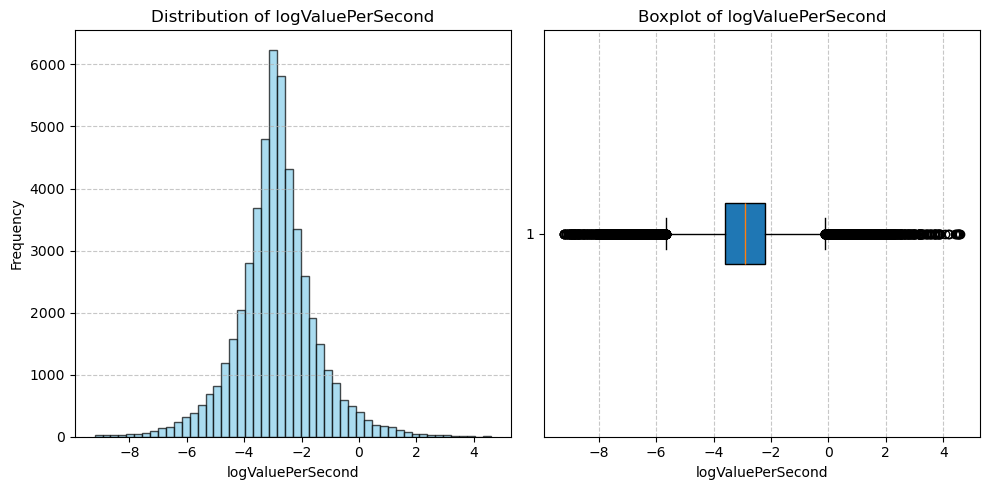

In [ ]:
X['logValuePerSecond'] = np.log(X['valuePerSecond']+1e-4)
plot_feature_dist('logValuePerSecond')

#### 3.2biii Further Analysis of `lineItemVoidsPerPosition`


This feature means the proportion of voided/canceled items to total scanned, non-canceled items. It makes sense tha this is right skewed because it's more likely for someone to void less or no items than more items. Therefore, this distribution is not abnormal.

Again, we log transform for better visualization.

##### Visualize new variable `logLineItemVoidsPerPosition`


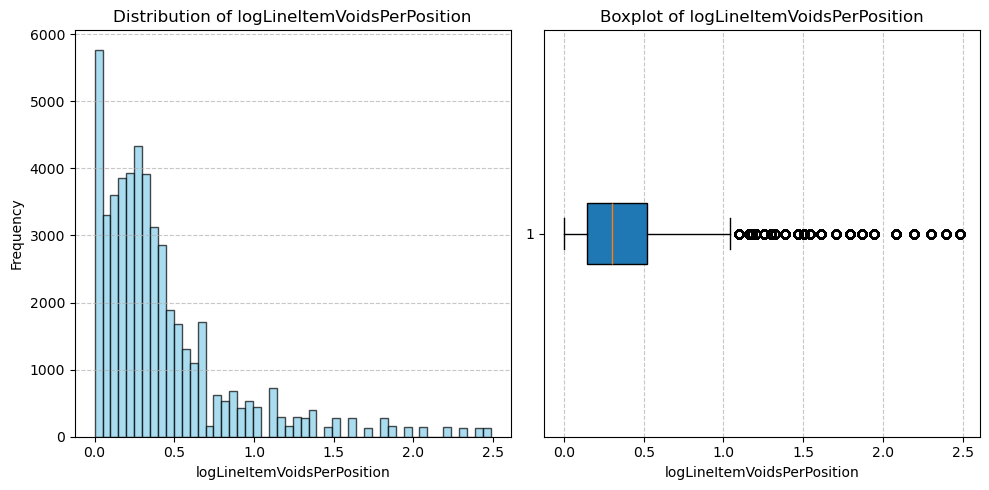

In [ ]:
X['logLineItemVoidsPerPosition'] = np.log(X['lineItemVoidsPerPosition']+1)
plot_feature_dist('logLineItemVoidsPerPosition')

## 3.3 Distribution of feature variables for fraud vs. not fraud







In [ ]:
"""
To clearly see the difference in the distributions of the features for fraud and non-fraud transactions, we plot both histograms and violin plots for the features. A violin plot is a combination of a boxplot and a kernel density plot. It shows the distribution of the data and the probability density of the data at different values.
"""

'\nTo clearly see the difference in the distributions of the features for fraud and non-fraud transactions, we plot both histograms and violin plots for the features. A violin plot is a combination of a boxplot and a kernel density plot. It shows the distribution of the data and the probability density of the data at different values.\n'

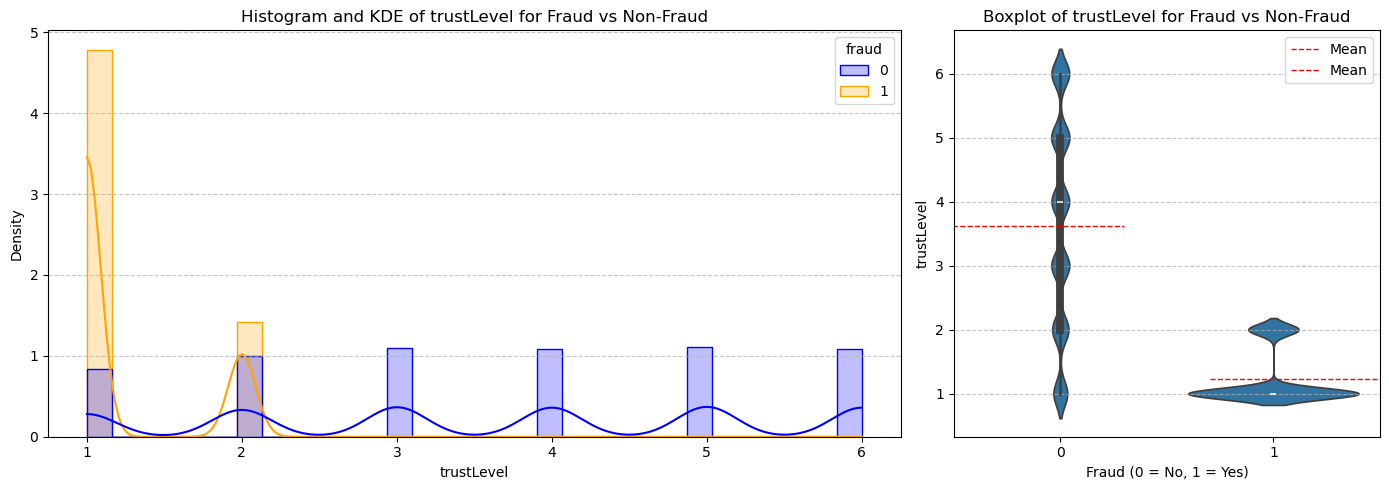

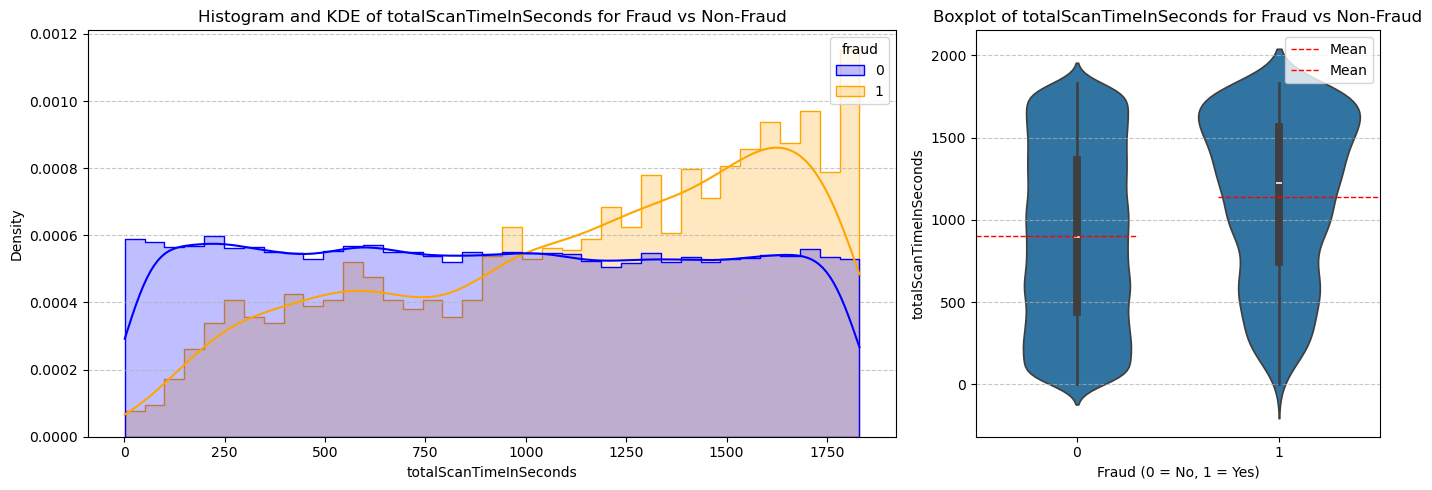

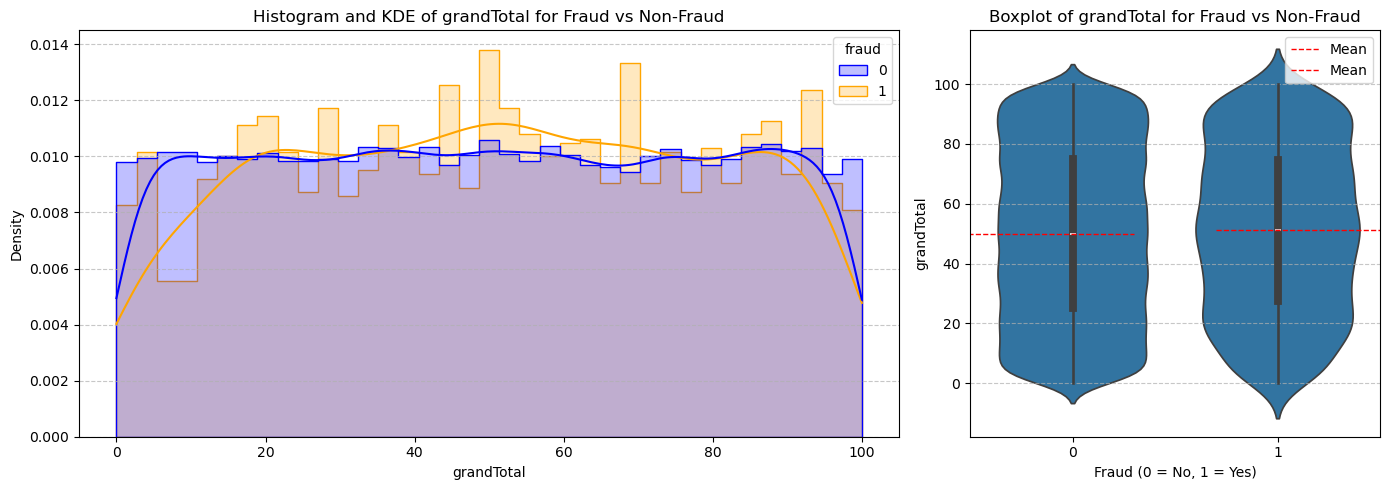

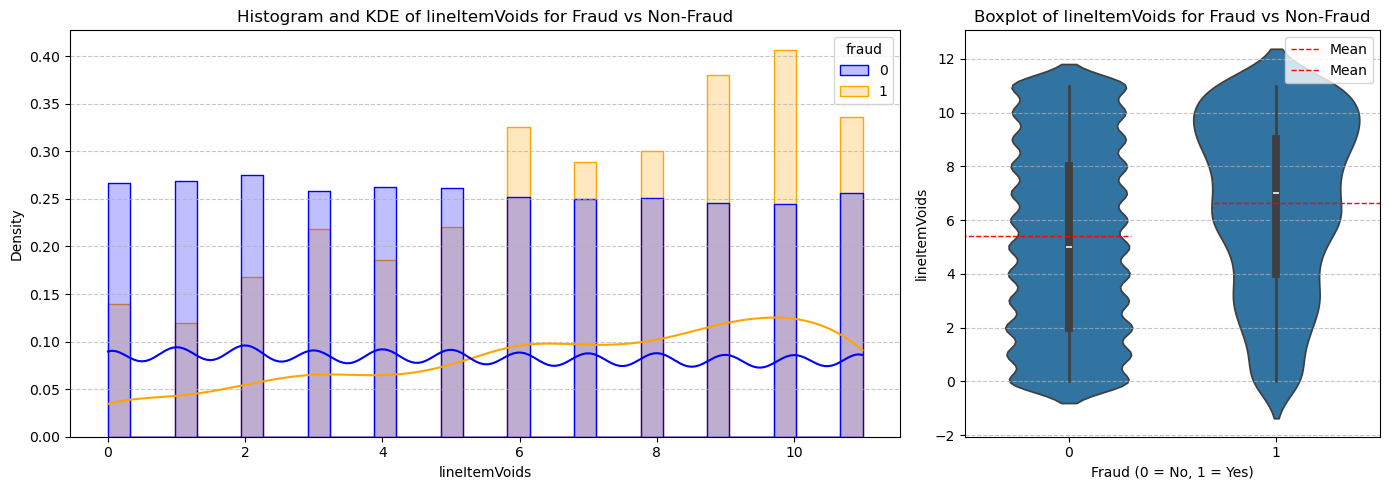

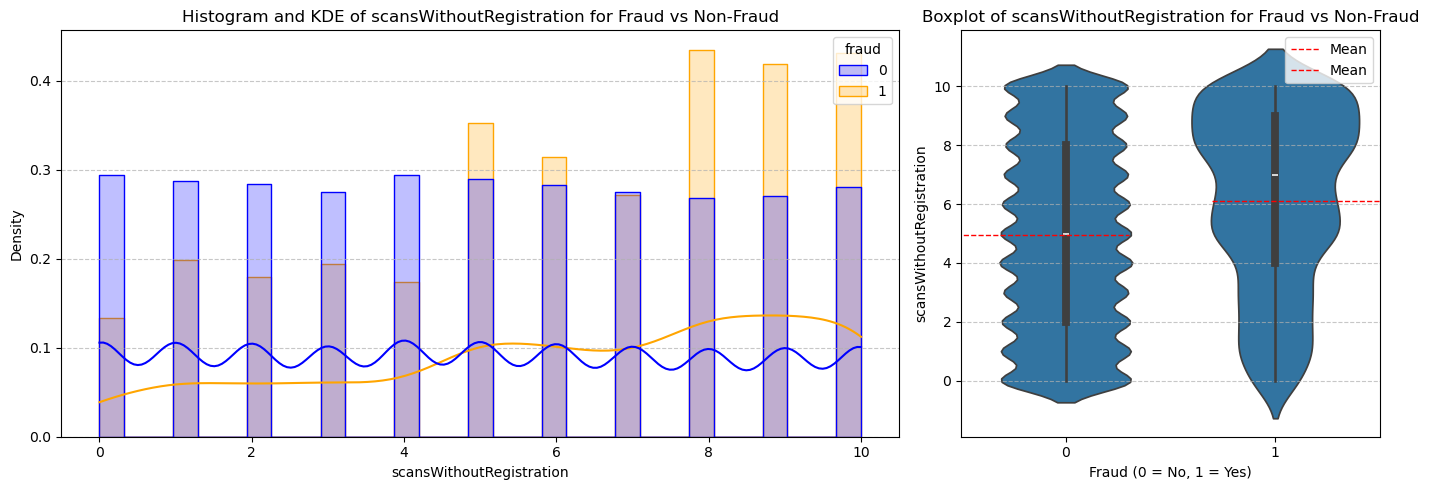

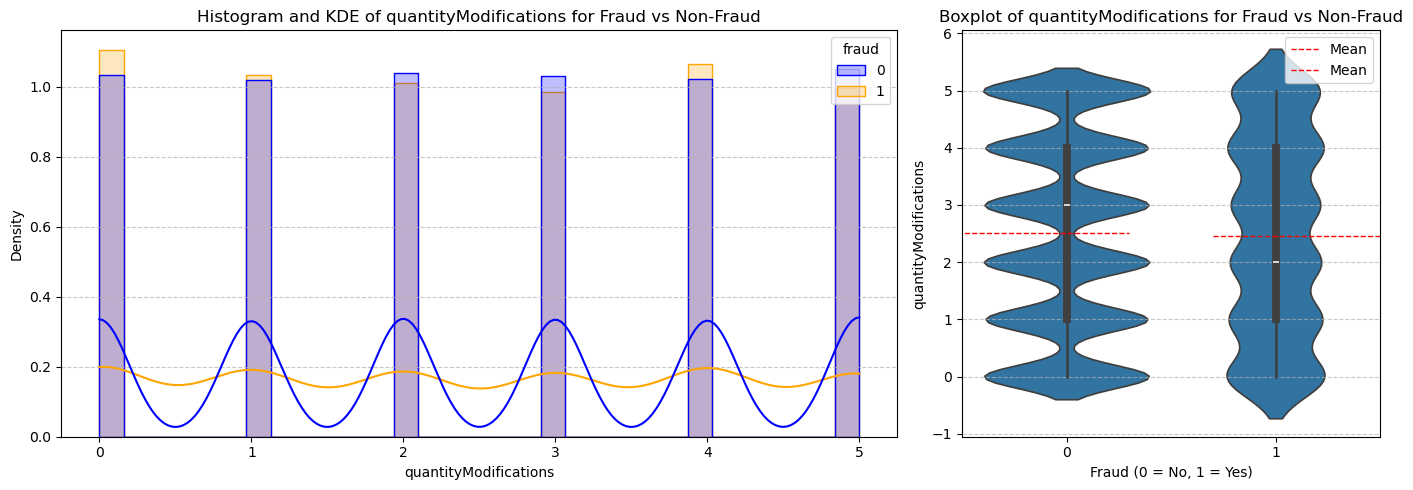

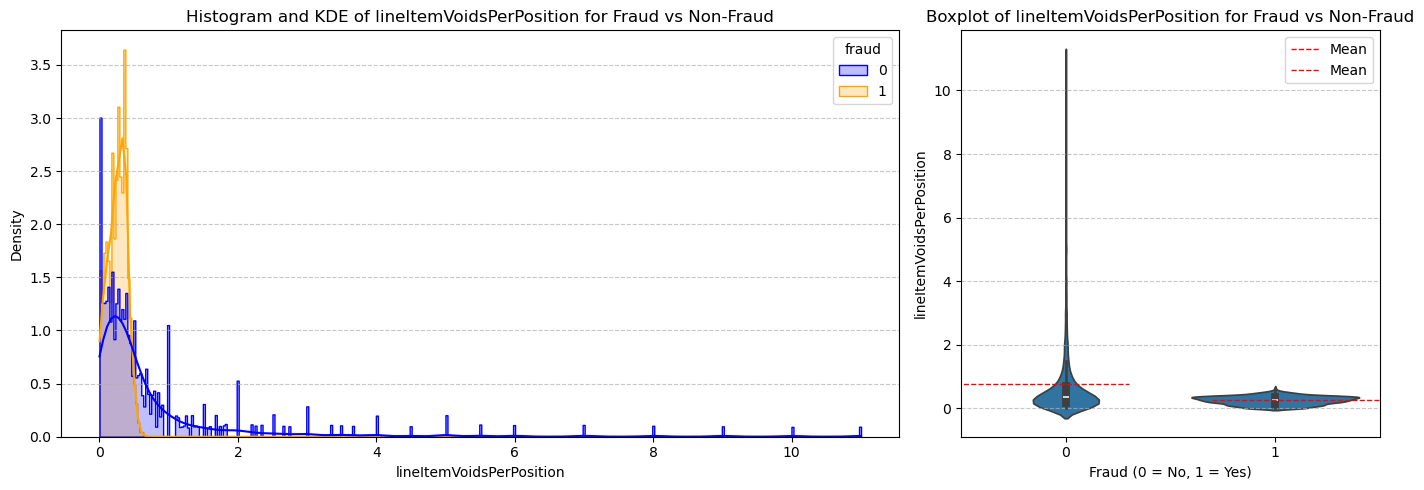

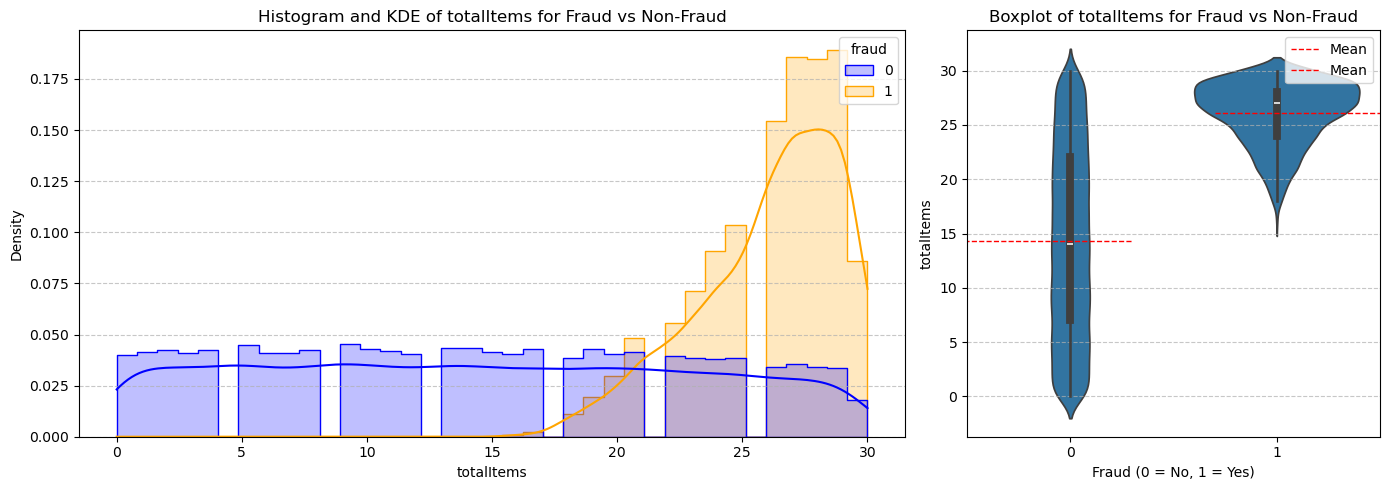

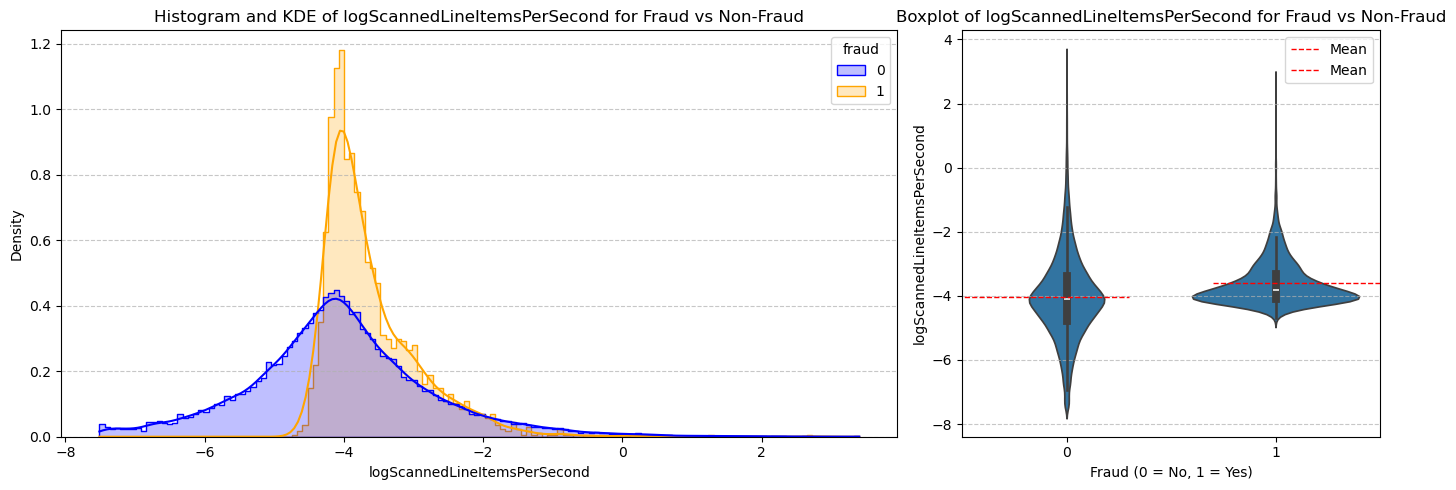

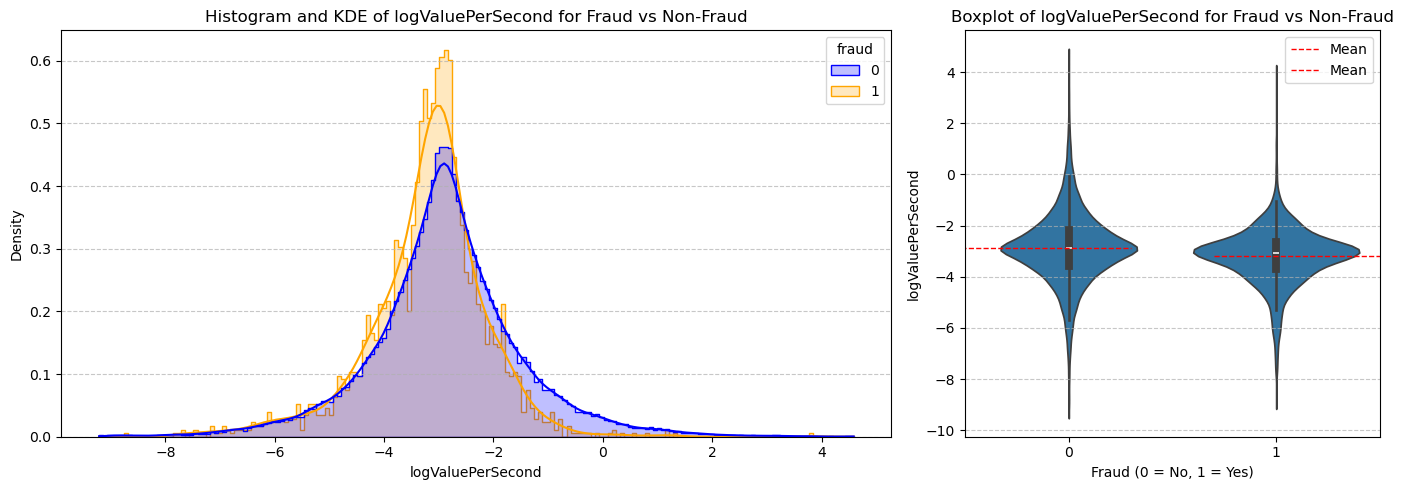

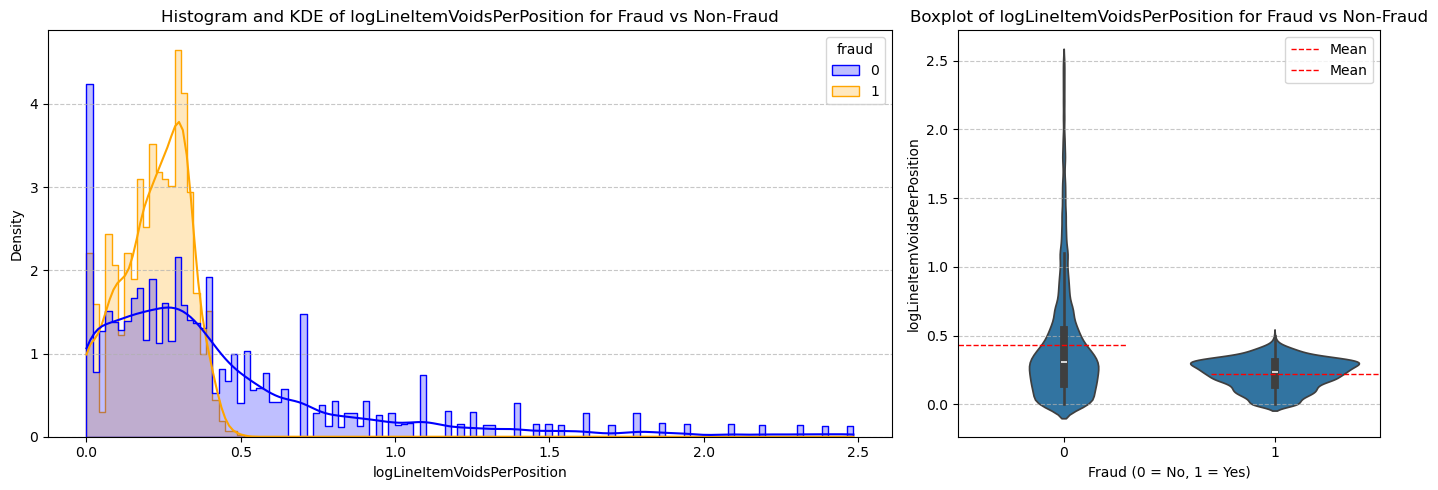

In [ ]:
cols_to_plot = ['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'lineItemVoidsPerPosition', 'totalItems',
       'logScannedLineItemsPerSecond', 'logValuePerSecond',
       'logLineItemVoidsPerPosition'
       ]
X['fraud'] = y
X["fraud"] = X["fraud"].astype(int)
# Plot histograms and boxplots side by side for each feature
for feature in cols_to_plot:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={"width_ratios": [2, 1]})

    # Histplot with KDE
    sns.histplot(
        data=X,
        x=feature,
        hue="fraud",
        element="step",
        stat="density",
        common_norm=False,
        kde=True,
        ax=axes[0],
        palette={0: "blue", 1: "orange"},
    )
    axes[0].set_title(f"Histogram and KDE of {feature} for Fraud vs Non-Fraud")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Density")
    axes[0].grid(axis="y", linestyle="--", alpha=0.7)

    # Boxplot
    # Violin plot with mean lines
    sns.violinplot(
        data=X,
        x="fraud",
        y=feature,
        ax=axes[1],
        # palette={0: "blue", 1: "orange"},
    )

    # Add mean lines for Fraud=0 and Fraud=1
    for fraud_value in [0, 1]:
        mean_value = X.loc[X["fraud"] == fraud_value, feature].mean()
        axes[1].axhline(
            y=mean_value,
            color="red",
            linestyle="--",
            linewidth=1,
            xmin=(fraud_value - 0.4),  # Adjust for alignment within violin
            xmax=(fraud_value + 0.4),
            label=f"Mean"  # Avoid duplicate labels
        )

    axes[1].set_title(f"Violin Plot of {feature} for Fraud vs Non-Fraud")
    axes[1].set_xlabel("Fraud (0 = No, 1 = Yes)")
    axes[1].set_ylabel(feature)
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)
    axes[1].legend(loc="upper right")  # Optional legend
    axes[1].set_title(f"Boxplot of {feature} for Fraud vs Non-Fraud")
    axes[1].set_xlabel("Fraud (0 = No, 1 = Yes)")
    axes[1].set_ylabel(feature)
    axes[1].grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

**Key Takeaways:**


**1.   Trust Level:** There is a fraud_rate of 21.75% for trustLevel = 1 and 6.49% for trustLevel = 2; however, there are no fraudulent cases for individuals with trust scores greater than 2 in our dataset (3-6).
- Since trustLevel is calculated from some unknown model, it begs the question what factors were included in predicting a customer's trustLevel. This finding furthers the notion that we should take a closer look at the impact of trustLevel in our modeling phase.

**2.   Total Scan time In Seconds:** We observe that the distribution of this feature for fraudulent transactions is left-skewed, which means that most of these transactions take longer time to scan. On the other hand, the scan time distribution of non-fraud transactions is close to uniform.

One possible explanation could be that fraudulent shoppers take more time in self-checkouts in an effort to compensate for skipping items to be scanned. In contrast, regular (non-fraudulent) shoppers can purchase various amounts of goods during any given shopping trip. This reinforces the idea that total scan time should not have any noticeable trend for non-fraudulent shoppers.

**3.   Line Item Voids:** Like the previous feature, we see left skewed distribution for fraudulent transactions and uniform distribution for non-fradulent ones. This variable measures the number of items scanned then deliberately removed from a customer's cart at self-checkout. The likelihood of fraudulent checkouts tends to increase with more item voids. Intuitively, this makes sense since customers may second-guess themselves paying for items during fraudulent checkouts and remove previously scanned from their carts. The same can be said for related feature `lineItemVoidsPerPosition`.

**4.   Scans Without Registration:** Again, we see the same trend in this feature as the previous two. Our findings suggest that fraudulent shoppers tend to attempt to scan more items without actually scanning the barcode. This intuitively makes sense since fraudulent shoppers may attempt to fool the self-checkout cameras by appearing to scan an item's barcode without actually registering it in the system and being charged for it.

**5.   Total Items:** We see two completely distributions for this feature. While non-fraud transactions observe a uniform distribution ranging from around 1 to 33, fraud exclusively occurs for transactions with greater than 15 items. Moreover, the distribution is left-skewed, with most fraud concentrating in the 25-30 items area.

One possible explanation is that shoppers believe it is easier to get away with fraud when they have more items, making it less obvious when some items are not scanned. This could also be a reason why fraudulent transactions have longer total scan times as well.

## 3.4 Correlation matrix between variables

Let's take a look at the correlation matrix to see if there's any correlated features.

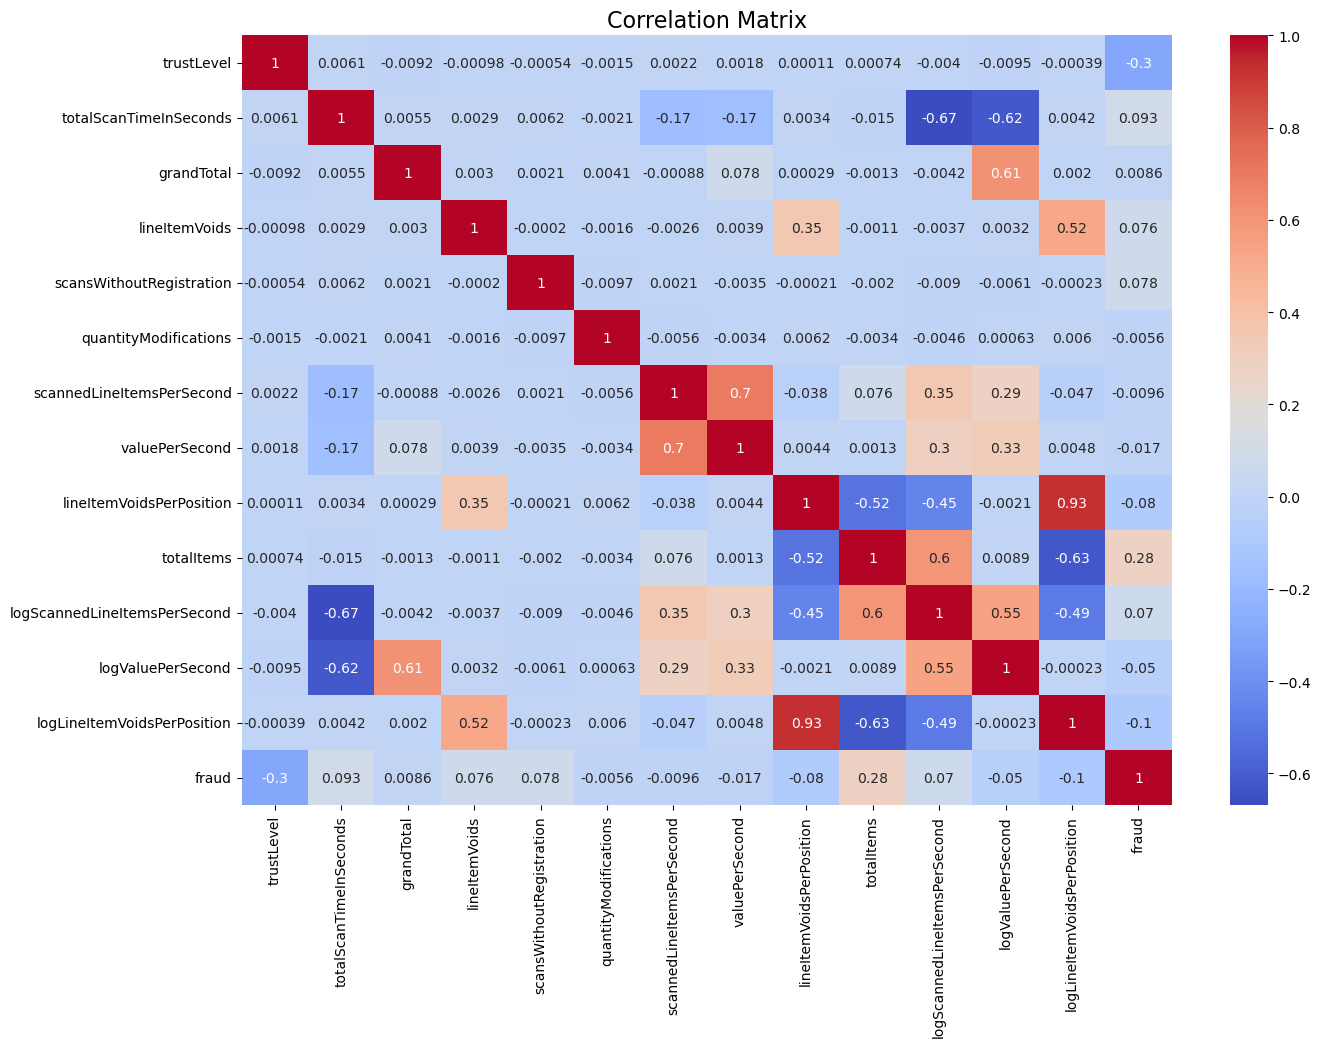

In [ ]:
corr_matrix = X.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16)
plt.show()

We find highly or moderately correlated features:

In [ ]:
correlations = corr_matrix.unstack().sort_values(ascending=False, key=abs).drop_duplicates().reset_index()
correlations.columns = ['Feature 1', 'Feature 2', 'Correlation']
correlations = correlations[correlations['Correlation'] < 0.9]
high_corr = correlations[abs(correlations['Correlation']) > 0.2]
high_corr

Feature 1                     Feature 2  Correlation
15     scannedLineItemsPerSecond                valuePerSecond     0.697980
16  logScannedLineItemsPerSecond        totalScanTimeInSeconds    -0.669492
17   logLineItemVoidsPerPosition                    totalItems    -0.627104
18             logValuePerSecond        totalScanTimeInSeconds    -0.618990
19             logValuePerSecond                    grandTotal     0.611692
20                    totalItems  logScannedLineItemsPerSecond     0.600064
21             logValuePerSecond  logScannedLineItemsPerSecond     0.546272
22   logLineItemVoidsPerPosition                 lineItemVoids     0.518965
23                    totalItems      lineItemVoidsPerPosition    -0.515655
24  logScannedLineItemsPerSecond   logLineItemVoidsPerPosition    -0.488228
25      lineItemVoidsPerPosition  logScannedLineItemsPerSecond    -0.450177
26      lineItemVoidsPerPosition                 lineItemVoids     0.353462
27     scannedLineItemsPerSecond  logScannedLineItemsPerSecond     0.352819
28             logValuePerSecond                valuePerSecond     0.325725
29  logScannedLineItemsPerSecond                valuePerSecond     0.296732
30                    trustLevel                         fraud    -0.295967
31             logValuePerSecond     scannedLineItemsPerSecond     0.287593
32                    totalItems                         fraud     0.281754

We notice that there are some high correlations between some of our feature variables. This is as expected since all of our features relate to some aspect of the self-checkout process (and some are calculated directly from one another like `scannedLineItemsPerSecond` and `fastScan`), making their measurements inherently similar.

High correlation between features does increase the risk of multicollinearity in our modeling. One method to address multicollinearity in our models is to use **Principal Components (PCA)** by creating a new feature space through dimensionality reduction by maximizing the variance in the data. By breaking strong correlations between features, this technique can improve a model like logistic regression whose coefficients can be skewed by the effect of highly correlated features.

For the proceeding analysis, we will standardize our data, so we will remove the log transformed features here.

In [ ]:
columns_to_drop = ['logScannedLineItemsPerSecond', 'logValuePerSecond', 'logLineItemVoidsPerPosition', 'fraud']
# we added 'fraud' to X earlier for visualization purposes, so we need to drop it now
X.drop(columns=columns_to_drop, inplace=True)
X.columns

Index(['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids',
       'scansWithoutRegistration', 'quantityModifications',
       'scannedLineItemsPerSecond', 'valuePerSecond',
       'lineItemVoidsPerPosition', 'totalItems'],
      dtype='object')

## 3.6 PCA: Looking at the data in a lower dimensional space


Since we have 10 features, we can't visualize it. Thus, we reduce our data to 3 dimensions and visualize it. Lower-dimensional representations often highlight dominant patterns or trends in the data, making it easier to understand the underlying structure.

Here we use Principal Component Analysis (PCA) for dimension reduction. As previously shown, some features are highly correlated, and they can contribute redundant information. PCA transforms the data into uncorrelated principal components, effectively capturing the unique contribution of each feature.

Before we proceed, we perform train-test-split to prevent data leakage because we may use insights from PCA to build our models.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

First, we need to standardize the features.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Now, we can use PCA to reduce the dimensionality of the data.

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

components = pca.components_
explained_variance = pca.explained_variance_ratio_

### 3.6a Plot of the cumulative explained variance

In [ ]:
# we want to see the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)
cumulative_explained_variance

array([0.17636885, 0.33741169, 0.43891163, 0.53971242, 0.63995421,
       0.73953673, 0.83862934, 0.92998861, 0.96766935, 1.        ])

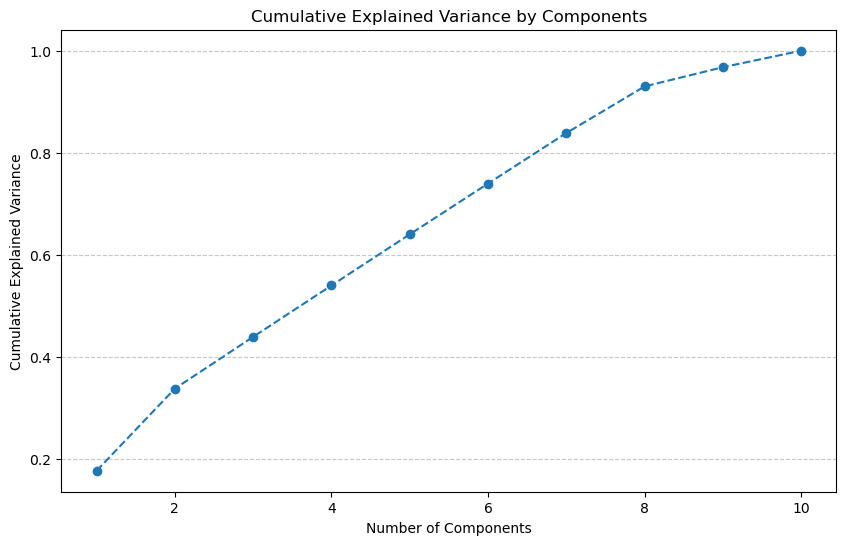

In [ ]:
# plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We see that in order to explain 93% of the variance in our data, we would need to use 8 out of 10 principal components (before the slope decreases). This indicates that our features are not as strongly correlated as we originally thought. In other words, this means that our features are fairly complex in predicting the target variable fraud.

In the modeling phase, we will test if incorporating PCA will benefit or hurt our model performance based off these results.

### 3.6b Plot of the 1st principal component

Let's take this a step further by examining the feature makeup of the first principal component.

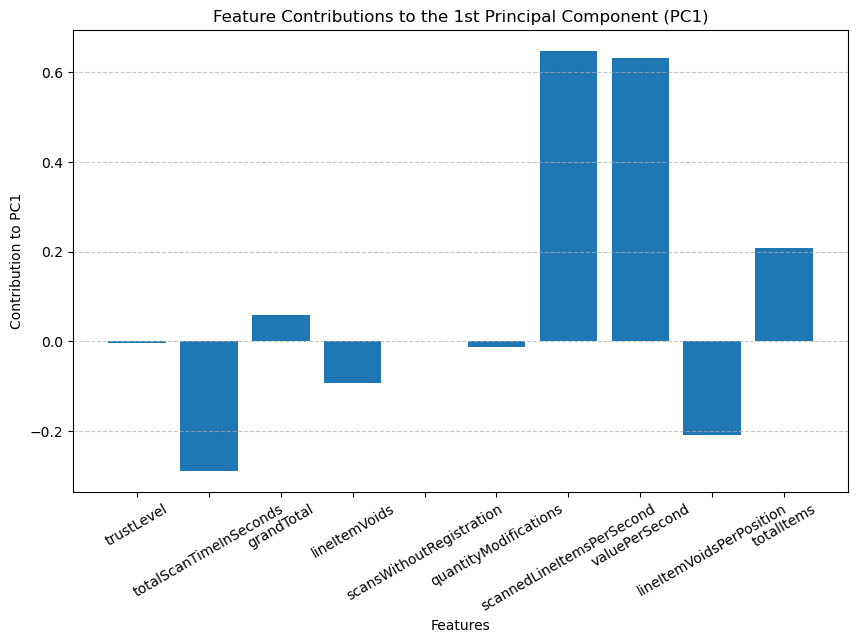

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(X.columns, components[0])
# rotate the x-axis labels for better readability
plt.xticks(rotation=30);
plt.title("Feature Contributions to the 1st Principal Component (PC1)")
plt.xlabel("Features")
plt.ylabel("Contribution to PC1")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

`scannedLineItemsPerSecond` and `valuePerSecond` contribute the most to a higher PC1 score, whereas `totalScanTimeInSeconds` and `lineItemVoidsPerPosition` have the largest negative effects on PC1 score. This suggests that a high PC1 score is capturing efficiency in scanning items quickly and not making mistakes such as voids.

### 3.6c Plot of the first three principal components

Now, let's visualize a plot of the first three principal components in an interactive, 3-D scatter plot. A interactive 3D scatter plot can be useful for understanding the relationships between data points and identifying clusters, outliers, or patterns in the data.

In [ ]:
import plotly.express as px
import plotly.graph_objs as go


fig = px.scatter_3d(
    X_train_pca,
    x=0,
    y=1,
    z=2,
    color=y_train.astype(str),
    opacity=0.7,
    labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'},
    title='3D Scatter Plot of 1st Three Principal Components',
    width=1000, height=600
)
fig.update_traces(marker=dict(size=2),
                  selector=dict(mode='markers'))
fig.write_html("file.html")
fig.show()


In [ ]:
# Just in case the 3D interactive plot does not render, here is the video
from IPython.display import Video
Video("3dInteractive.mov", width=800, height=600)

From the 3D scatter plot, we see that the variance of non-fraudulent checkouts is much greater than fraudulent checkouts. This finding aligns with our prior plots where non-frauduent checkouts displayed more uniform feature distributions. Conversely, fraudulent checkouts mostly sit at the corner of PC1 and PC3.

# Part 4: Hypothesis Testing

We will conduct 5 hypothesis tests. For each of the features in {`totalItems`, `totalScanTimeInSeconds`, `lineItemVoids`, `scansWithoutRegistration`, `quantityModifications`}, we will test if there is a significant difference in the means of those features between fraud and non-fraud transactions.

Our p-value is 0.05 / 5 = 0.01

In [ ]:
def bootstrap_test_with_distribution(group1, group2, num_resamples=10000, ci = 0.99):
    np.random.seed(42)

    observed_stat = abs(group1.mean() - group2.mean())
    bootstrap_stats = []

    for _ in range(num_resamples):
        sample1 = np.random.choice(group1, size=len(group1), replace=True)
        sample2 = np.random.choice(group2, size=len(group2), replace=True)
        bootstrap_stat = abs(sample1.mean() - sample2.mean())
        bootstrap_stats.append(bootstrap_stat)

    lower_bound = np.percentile(bootstrap_stats, (1 - ci) / 2 * 100)
    upper_bound = np.percentile(bootstrap_stats, (1 + ci) / 2 * 100)
    return observed_stat, bootstrap_stats, lower_bound, upper_bound

# Function for permutation test
def permutation_test(group1, group2, num_permutations=10000):
    observed_diff = np.mean(group1) - np.mean(group2)
    combined = np.concatenate([group1, group2])
    perm_diffs = []

    np.random.seed(42)
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        perm_group1 = combined[:len(group1)]
        perm_group2 = combined[len(group1):]
        perm_diffs.append(np.mean(perm_group1) - np.mean(perm_group2))

    p_value = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / num_permutations
    return observed_diff, perm_diffs, p_value


def plot_confidence_interval(bootstrap_stats, observed_stat, lower_bound, upper_bound, feature_name):
    plt.hist(bootstrap_stats, bins=50, edgecolor='k', alpha=0.7, color='skyblue')
    plt.axvline(observed_stat, color='red', linestyle='--', label='Observed Statistic')
    plt.axvline(lower_bound, color='green', linestyle='--', label='Confidence Interval')
    plt.axvline(upper_bound, color='green', linestyle='--')
    plt.title(f'Bootstrapped Distribution of Difference in Means for {feature_name}')
    plt.xlabel('Difference in Means')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_permutation_test(perm_diffs, observed_diff, feature_name):
    plt.hist(perm_diffs, bins=50, edgecolor='k', alpha=0.7, color='skyblue')
    plt.axvline(observed_diff, color='red', linestyle='--', label='Observed Difference')
    plt.title(f'Permutation Test for Difference in Means for {feature_name}')
    plt.xlabel('Difference in Means')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
fraud_group = X[y == 1]
non_fraud_group = X[y == 0]
P_VAL = 0.01


To visualize the result of bootstrapped confidence intervals and permutation tests, we will plot historgrams of the bootstrapped statistics and permutation statistics, respectively.


## 4.1 `totalItems`

$H_0$: There is no difference in the mean of `totalItems` between fraud and non-fraud transactions

$H_a$: The mean of `totalItems` in fraud transactions is higher than the mean of `totalItems` in non-fraud transactions

In [ ]:
fraud_group = X[y == 1]['totalItems']
non_fraud_group = X[y == 0]['totalItems']

observed_stat, bootstrap_stats, lower_bound, upper_bound = bootstrap_test_with_distribution(fraud_group, non_fraud_group)
observed_diff, perm_diffs, p_value = permutation_test(fraud_group, non_fraud_group)


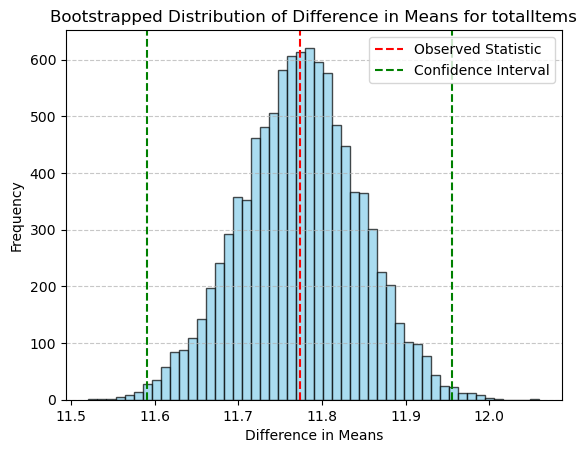

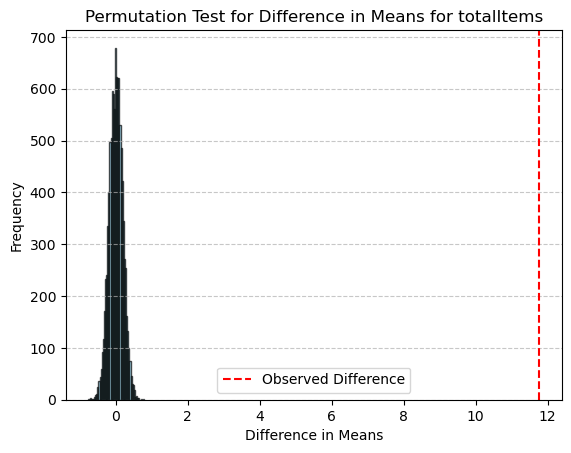

The obsedved mean difference is 11.773578752466134
The 99% confidence interval for the difference in means is (11.59, 11.96)
The p-value for the permutation test is 0.00000


In [ ]:
plot_confidence_interval(bootstrap_stats, observed_stat, lower_bound, upper_bound, 'totalItems')
plot_permutation_test(perm_diffs, observed_diff, 'totalItems')
print(f"The obsedved mean difference is {observed_stat}")
print(f"The 99% confidence interval for the difference in means is ({lower_bound:.2f}, {upper_bound:.2f})")
print(f"The p-value for the permutation test is {p_value:.5f}")

**Interpretation**:

The 99% confidence interval of the mean difference in totalItems between fraud and non-fraud transactions is (11.59, 11.96), which does not include 0. This means that if we were to repeatedly sample and calculate the interval, 99% of those intervals would contain the true mean difference in totalItems between fraud and non-fraud transactions. Because this interval does not include 0, we have strong evidence that the true mean difference is not 0

Furthermore, the permutation test yielded a p-value of near 0, which is well below the threshold 0.01. Therefore, we reject the null hypothesis that there is no difference in the mean number of items scanned between fraud and non-fraud transactions. This result provides strong statistical evidence that fraud transactions involve significantly more items scanned than non-fraud transactions. Therefore, we anticipate this feature to be very useful in identifying fraudulent behavior.

## 4.2 `totalScanTimeInSeconds`

$H_0$: There is no difference in the mean of `totalScanTimeInSeconds` between fraud and non-fraud transactions

$H_a$: The mean of `totalScanTimeInSeconds` in fraud transactions is higher than the mean of `totalScanTimeInSeconds` in non-fraud transactions

In [ ]:
fraud_group = X[y == 1]['totalScanTimeInSeconds']
non_fraud_group = X[y == 0]['totalScanTimeInSeconds']

observed_stat, bootstrap_stats, lower_bound, upper_bound = bootstrap_test_with_distribution(fraud_group, non_fraud_group)
observed_diff, perm_diffs, p_value = permutation_test(fraud_group, non_fraud_group)

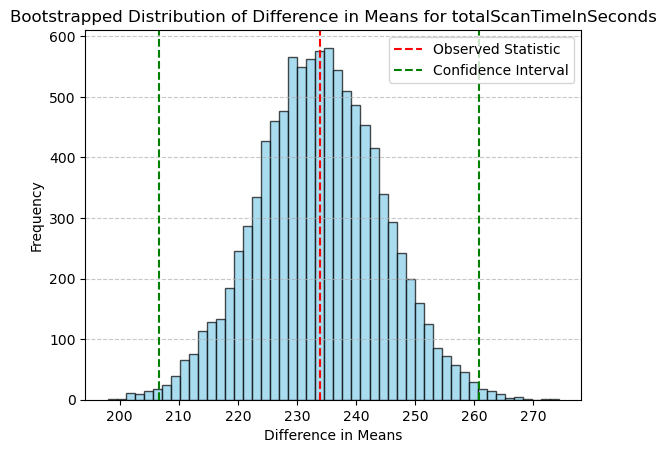

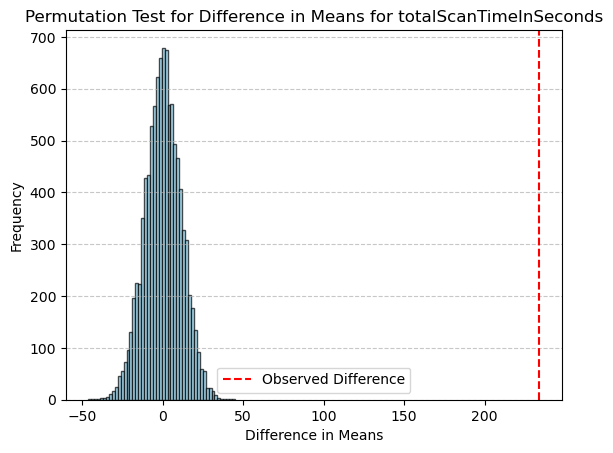

The obsedved mean difference is 233.92802529531377
The 99% confidence interval for the difference in means is (206.63, 260.76)
The p-value for the permutation test is 0.00000


In [ ]:
plot_confidence_interval(bootstrap_stats, observed_stat, lower_bound, upper_bound, 'totalScanTimeInSeconds')
plot_permutation_test(perm_diffs, observed_diff, 'totalScanTimeInSeconds')
print(f"The obsedved mean difference is {observed_stat}")
print(f"The 99% confidence interval for the difference in means is ({lower_bound:.2f}, {upper_bound:.2f})")
print(f"The p-value for the permutation test is {p_value:.5f}")

**Interpretation:**

The 99% confidence interval of the mean difference in `totalScanTimeInSeconds` between fraud and non-fraud transactions is (206.63, 260.76), which does not include 0. This means that if we were to repeatedly sample and calculate the interval, 99% of those intervals would contain the true mean difference in `totalScanTimeInSeconds` between fraud and non-fraud transactions. Because this interval does not include 0, we have strong evidence that the true mean difference is not 0

Furthermore, the permutation test yielded a p-value of near 0, which is well below the threshold 0.01. Therefore, we reject the null hypothesis that there is no difference in the mean scan time in seconds between fraud and non-fraud transactions. This result provides strong statistical evidence that fraud transactions take significantly longer than non-fraud transactions. Therefore, we anticipate this feature to be very useful in identifying fraudulent behavior.

## 4.3 `lineItemVoids`

$H_0$: There is no difference in the mean of `lineItemVoids` between fraud and non-fraud transactions

$H_a$: The mean of `lineItemVoids` in fraud transactions is higher than the mean of `lineItemVoids` in non-fraud transactions

In [ ]:
fraud_group = X[y == 1]['lineItemVoids']
non_fraud_group = X[y == 0]['lineItemVoids']

observed_stat, bootstrap_stats, lower_bound, upper_bound = bootstrap_test_with_distribution(fraud_group, non_fraud_group)
observed_diff, perm_diffs, p_value = permutation_test(fraud_group, non_fraud_group)

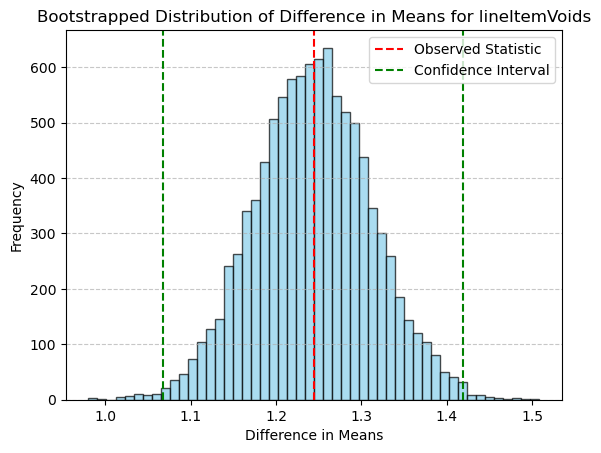

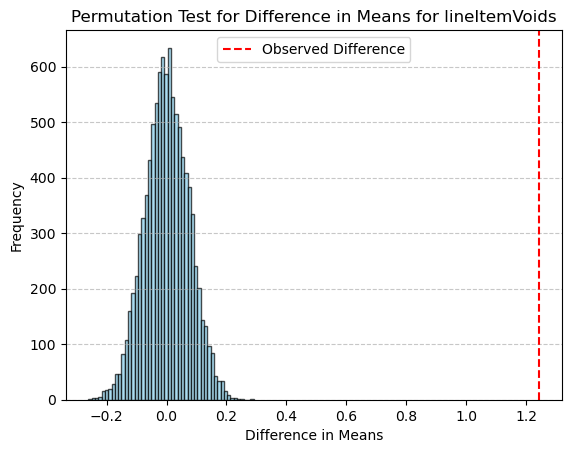

The obsedved mean difference is 1.2440865284484124
The 99% confidence interval for the difference in means is (1.07, 1.42)
The p-value for the permutation test is 0.00000


In [ ]:
plot_confidence_interval(bootstrap_stats, observed_stat, lower_bound, upper_bound, 'lineItemVoids')
plot_permutation_test(perm_diffs, observed_diff, 'lineItemVoids')
print(f"The obsedved mean difference is {observed_stat}")
print(f"The 99% confidence interval for the difference in means is ({lower_bound:.2f}, {upper_bound:.2f})")
print(f"The p-value for the permutation test is {p_value:.5f}")

**Interpretation:**

The 99% confidence interval of the mean difference in `lineItemVoids` between fraud and non-fraud transactions is (1.07, 1.42), which does not include 0. This means that if we were to repeatedly sample and calculate the interval, 99% of those intervals would contain the true mean difference in `lineItemVoids` between fraud and non-fraud transactions. Because this interval does not include 0, we have strong evidence that the true mean difference is not 0

Furthermore, the permutation test yielded a p-value of near 0, which is well below the threshold 0.01. Therefore, we reject the null hypothesis that there is no difference in the mean number of voided scans between fraud and non-fraud transactions. This result provides strong statistical evidence that fraud transactions have significantly more voided scans than non-fraud transactions. Therefore, we anticipate this feature to be very useful in identifying fraudulent behavior.

## 4.4 `scansWithoutRegistration`

$H_0$: There is no difference in the mean of `scansWithoutRegistration` between fraud and non-fraud transactions

$H_a$: The mean of `scansWithoutRegistration` in fraud transactions is higher than the mean of `scansWithoutRegistration` in non-fraud transactions

In [ ]:
fraud_group = X[y == 1]['scansWithoutRegistration']
non_fraud_group = X[y == 0]['scansWithoutRegistration']

observed_stat, bootstrap_stats, lower_bound, upper_bound = bootstrap_test_with_distribution(fraud_group, non_fraud_group)
observed_diff, perm_diffs, p_value = permutation_test(fraud_group, non_fraud_group)

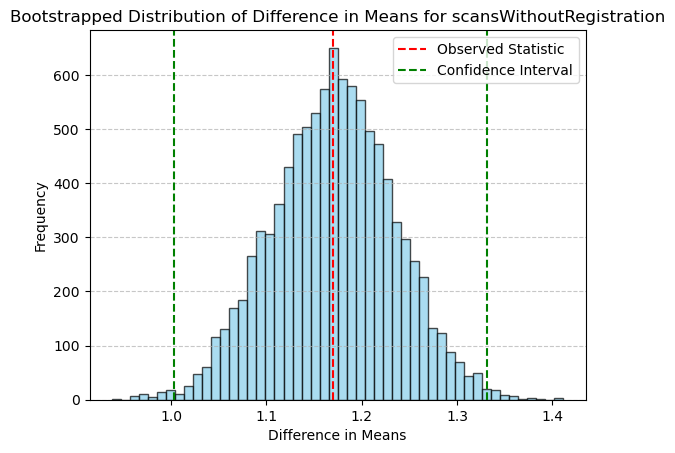

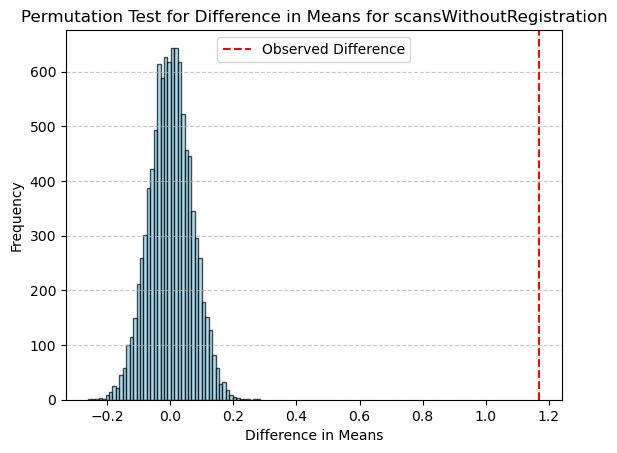

The obsedved mean difference is 1.1699833223247529
The 99% confidence interval for the difference in means is (1.00, 1.33)
The p-value for the permutation test is 0.00000


In [ ]:
plot_confidence_interval(bootstrap_stats, observed_stat, lower_bound, upper_bound, 'scansWithoutRegistration')
plot_permutation_test(perm_diffs, observed_diff, 'scansWithoutRegistration')
print(f"The obsedved mean difference is {observed_stat}")
print(f"The 99% confidence interval for the difference in means is ({lower_bound:.2f}, {upper_bound:.2f})")
print(f"The p-value for the permutation test is {p_value:.5f}")

**Interpretation:**

The 99% confidence interval of the mean difference in `scansWithoutRegistration` between fraud and non-fraud transactions is (1.00, 1.33), which does not include 0. This means that if we were to repeatedly sample and calculate the interval, 99% of those intervals would contain the true mean difference in `scansWithoutRegistration` between fraud and non-fraud transactions. Because this interval does not include 0, we have strong evidence that the true mean difference is not 0.

Furthermore, the permutation test yielded a p-value of near 0, which is well below the threshold 0.01. Therefore, we reject the null hypothesis that there is no difference between fraud and non-fraud transactions in the mean number of attempts to activate the scanner without actually scanning anything. This result provides strong statistical evidence that fraud transactions have significantly more scans without registration than non-fraud transactions. Therefore, we anticipate this feature to be very useful in identifying fraudulent behavior.

## 4.5 `quantityModifications`

$H_0$: There is no difference in the mean of `quantityModifications` between fraud and non-fraud transactions

$H_a$: The mean of `quantityModifications` in fraud transactions is higher than the mean of `quantityModifications` in non-fraud transactions

In [ ]:
fraud_group = X[y == 1]['quantityModifications']
non_fraud_group = X[y == 0]['quantityModifications']

observed_stat, bootstrap_stats, lower_bound, upper_bound = bootstrap_test_with_distribution(fraud_group, non_fraud_group)
observed_diff, perm_diffs, p_value = permutation_test(fraud_group, non_fraud_group)

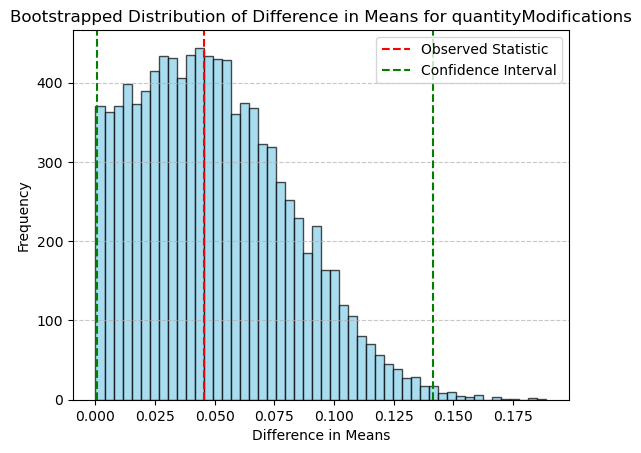

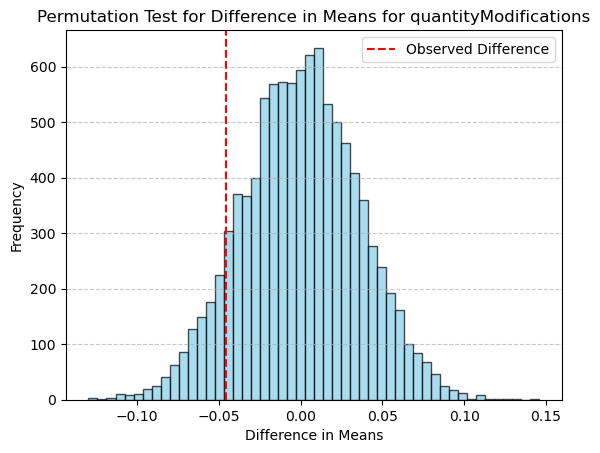

The obsedved mean difference is 0.045612009653390295
The 99% confidence interval for the difference in means is (0.00, 0.14)
The p-value for the permutation test is 0.20630


In [ ]:
plot_confidence_interval(bootstrap_stats, observed_stat, lower_bound, upper_bound, 'quantityModifications')
plot_permutation_test(perm_diffs, observed_diff, 'quantityModifications')
print(f"The obsedved mean difference is {observed_stat}")
print(f"The 99% confidence interval for the difference in means is ({lower_bound:.2f}, {upper_bound:.2f})")
print(f"The p-value for the permutation test is {p_value:.5f}")

**Interpretation:**

The 99% confidence interval of the mean difference in `quantityModifications` between fraud and non-fraud transactions is (0.00, 0.14), which includes 0. This means that if we were to repeatedly sample and calculate the interval, 99% of those intervals would contain the true mean difference in `quantityModifications` between fraud and non-fraud transactions. Because this interval includes 0, it is extremely likely that the true mean difference is 0.

Furthermore, the permutation test yielded a p-value of about 0.21, which is well above the threshold 0.01. Therefore, we fail to reject the null hypothesis that there is no difference between fraud and non-fraud transactions in the mean number of modified quantities for a scanned product. This result provides insufficient statistical evidence that fraud transactions have significantly more scans with modified quantities than non-fraud transactions. Therefore, we do not anticipate this feature to be useful in identifying fraudulent behavior.

# Part 5: Modeling

## 5.1 Baseline Modeling

Here we train and evaluate some baseline models as a benchmark. The baseline models will have all default hyperparameters and will be trained on the standardized orginal data (not including engineered features).

We choose Logistic Regresssion, Random Forest, and SVM.

Through Logistic Regression and SVM (with the default linear kernel) we can see if our data is inherently linearly separable. If it is, then we can expect good performance from these models. If not, then we can Random Forest, which is a non-linear model, may perhaps give good results.

Furthermore, Logistic Regression is simple and interpretable, making it ideal for establishing a performance baseline and providing easily understandable results for binary classification tasks. Random Forest can handle non-linear relationships and is robustness against overfitting. Its feature importance metrics help identify key drivers of predictions. Lastly, SVM can also model complex, non-linear decision boundaries via the kernel trick.

This diverse set of models allows us to tackle both linear and non-linear problems, compare simple and complex model behaviors, and understand the impact of different features on the predictions,

### 5.1a Helper functions to use in model evaluation

In [ ]:
def plot_confusion_matrix(y_true, y_pred, ax=None):
    """
    Plots a confusion matrix based on the true labels and predicted labels.
    Parameters:
    - y_true (array-like): The true labels.
    - y_pred (array-like): The predicted labels.
    - ax (matplotlib.axes.Axes, optional): The axes on which to plot the confusion matrix. If not provided, a new figure and axes will be created.
    Returns:
    - cm (array-like): The normalized confusion matrix.
    """

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    if ax is None:
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix', fontsize=15)
    else:
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')

    return cm

def evaluate_model(y_true, y_pred, print_report=True):
    """
    Evaluate the performance of a classification model.

    Parameters:
    - y_true (array-like): The true labels.
    - y_pred (array-like): The predicted labels.
    - print_report (bool, optional): Whether to print the evaluation report. Default is True.

    Returns:
    - precision (float): The precision score.
    - recall (float): The recall score.
    - f1_score (float): The F1 score.
    - accuracy (float): The accuracy score.
    """

    # calculate precision, recall, f1-score, and roc-auc (if y_proba is not None)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    if print_report:
        print(f"Precision: {precision:.5f}")
        print(f"Recall: {recall:.5f}")
        print(f"F1 Score: {f1_score:.5f}")
        print(f"Accuracy: {accuracy_score(y_true, y_pred):.5f}")

    return precision, recall, f1_score, accuracy_score(y_true, y_pred)

### 5.1b Train and evaluate baseline Models

Here we drop the `totalItems` feature, train-test-split the data, and standardize the trainig data.

In [ ]:
engineered_features = ['totalItems']
X_without_engineered = X.drop(columns=engineered_features)
X_train, X_test, y_train, y_test = train_test_split(X_without_engineered, y, test_size=0.2, random_state=42)
scaler_without_engineered = StandardScaler()
X_train = scaler_without_engineered.fit_transform(X_train)
X_test = scaler_without_engineered.transform(X_test)

Now we build Logistic Regression, Random Forest, and SVM with this data as our baseline.

precision    recall        f1  accuracy
Logistic Regression   0.905983  0.689805  0.783251    0.9824
Random Forest         0.942928  0.824295  0.879630    0.9896
SVM                   0.887218  0.511931  0.649243    0.9745

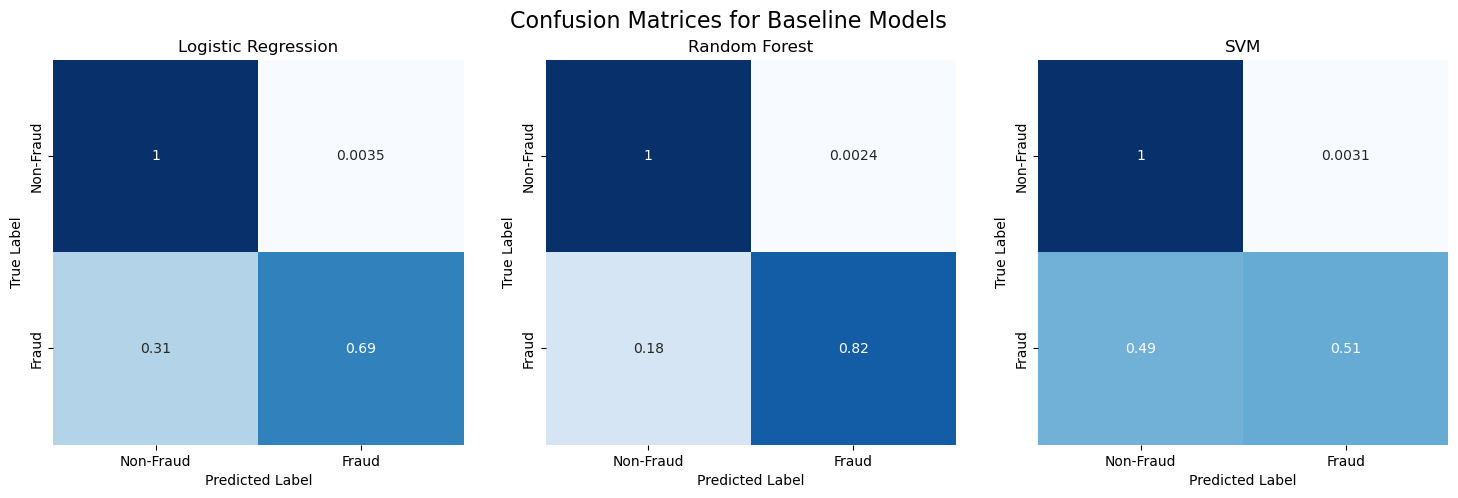

In [ ]:
logistic_regression = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier(n_jobs=-1, random_state=42)
svm = SVC()

models = [logistic_regression, random_forest, svm]
model_names = ['Logistic Regression', 'Random Forest', 'SVM']
model_metrics = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices for Baseline Models', fontsize=16)
axes = axes.flatten()
for i, (model, name) in enumerate(zip(models, model_names)):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, ax = axes[i])
    axes[i].set_title(name)
    p, r, f1, acc = evaluate_model(y_test, y_pred, print_report=False)
    model_metrics[name] = {'precision': p, 'recall': r, 'f1': f1, 'accuracy': acc}

baseline_metrics = pd.DataFrame(model_metrics).T
baseline_metrics

Logistic Regression and SVM both have very low recall. This suggests that the original data is not linearly separable. Random Forest performs much better because it can capture non-linear relationships in the data.

## 5.2 Baseline Modeling with engineered feature `totalItems`  

precision    recall        f1  accuracy
Logistic Regression   0.944186  0.880694  0.911336    0.9921
Random Forest         0.951163  0.887202  0.918070    0.9927
SVM                   0.932432  0.898048  0.914917    0.9923

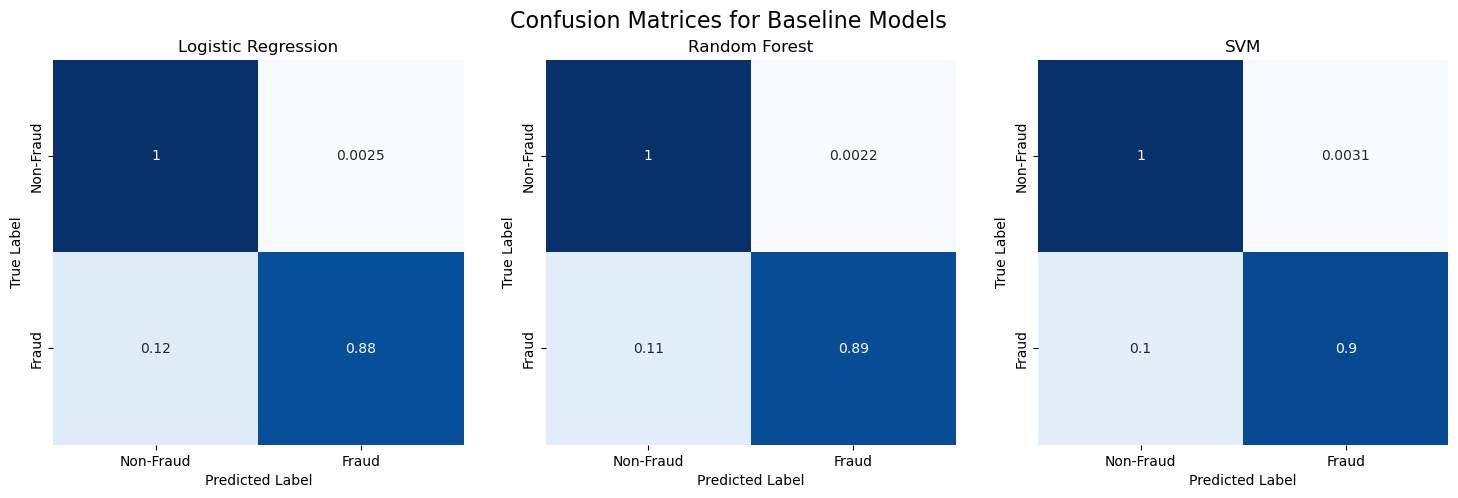

In [ ]:
logistic_regression = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier(n_jobs=-1, random_state=42)
svm = SVC()

models = [logistic_regression, random_forest, svm]
model_names = ['Logistic Regression', 'Random Forest', 'SVM']
model_metrics = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices for Baseline Models', fontsize=16)
axes = axes.flatten()
for i, (model, name) in enumerate(zip(models, model_names)):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    plot_confusion_matrix(y_test, y_pred, ax = axes[i])
    axes[i].set_title(name)
    p, r, f1, acc = evaluate_model(y_test, y_pred, print_report=False)
    model_metrics[name] = {'precision': p, 'recall': r, 'f1': f1, 'accuracy': acc}

with_engineered_metrics = pd.DataFrame(model_metrics).T
with_engineered_metrics

We see some significant improvements. We analyze the improvements in the next section.

### 5.2a Comparison of baseline model performance with/without `totalItems`

We will use paired bar plots to compare the performance of the models with and without the engineered feature. Paired bar plots are useful for comparing two groups across multiple categories.

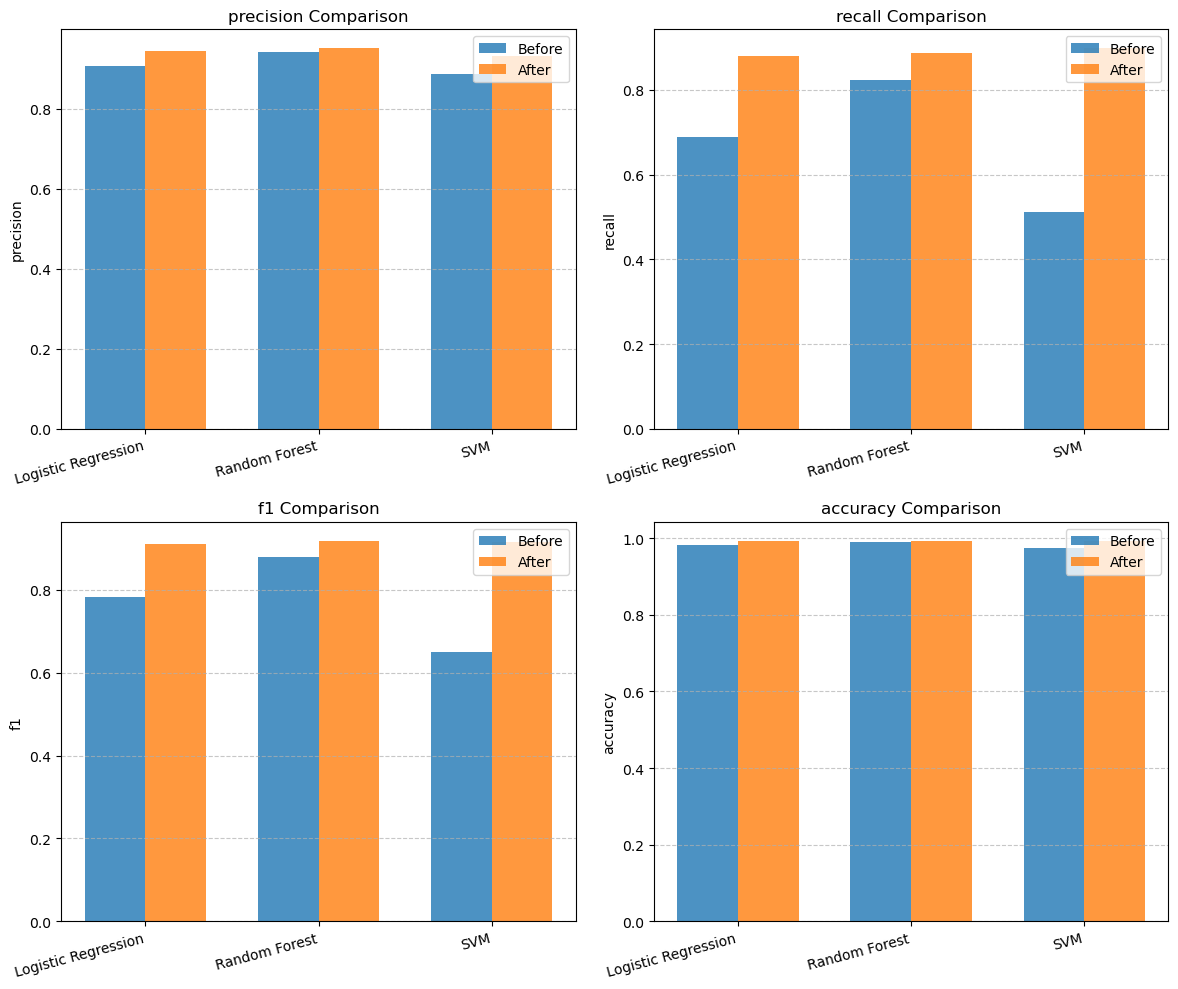

In [ ]:
# Metrics to compare
metrics = ['precision', 'recall', 'f1', 'accuracy']
x_labels = model_names

# Plot paired bar plots for each metric
x = np.arange(len(x_labels))  # Label locations
width = 0.35  # Width of the bars

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.bar(x - width/2, baseline_metrics[metric], width, label='Before', alpha=0.8)
    ax.bar(x + width/2, with_engineered_metrics[metric], width, label='After', alpha=0.8)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=15, ha='right')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Let's see how much, in percentage, did our models improve

In [ ]:
(with_engineered_metrics - baseline_metrics ) / baseline_metrics

precision    recall        f1  accuracy
Logistic Regression   0.042168  0.276730  0.163529  0.009874
Random Forest         0.008733  0.076316  0.043700  0.003133
SVM                   0.050962  0.754237  0.409205  0.018266

From the above plots and table, we see that the engineered feature `totalItems` significantly improve all baseline models.

1. Logistic Regression:
    - Demonstrates the most balanced improvement across metrics, particularly in Recall (+27.67%) and F1 (+16.35%), with modest gains in Precision and Accuracy.
2. Random Forest:
    - Shows incremental improvements, with notable gains in Recall (+7.63%) and smaller enhancements in other metrics.
3. SVM:
    - Achieves the most significant boost in Recall (+75.42%) and F1 (+40.92%), making it highly effective for recall-critical tasks like fraud detection.

The fact that Logistic Regression and SVM saw a significant increase in performance suggests that the additional features makes the data linearly separable.

## 5.3 Modeling with PCA

As previously discussed, adding PCA to our modeling process may help address multicollinearity in our logistic regression and maybe in our SVM model as well. Let's test out this theory by incorporating the first Principal Component (PC1) into the training data and evluate model performance.

In section 3.6b, we showed that `scannedLineItemsPerSecond`, `valuePerSecond`, and `totalScanTimeInSeconds` contribute the most to PC1, which means if we replace these 3 features with PC1, we still retain a good ammount of information from those 3 features. Therefore, we use PC1 to replace those features.

In [ ]:
PC1_features = ["totalScanTimeInSeconds", "valuePerSecond", "scannedLineItemsPerSecond"]

X_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca = pd.DataFrame(pca.transform(X_test_scaled), columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])

X_with_pca_train = pd.concat([X_train_scaled, X_train_pca[['PC1']]], axis=1)
X_with_pca_test = pd.concat([X_test_scaled, X_test_pca[['PC1']]], axis=1)

# drop the original features used to create PC1
X_with_pca_train.drop(columns=PC1_features, inplace=True)
X_with_pca_test.drop(columns=PC1_features, inplace=True)

Training and evaluating models

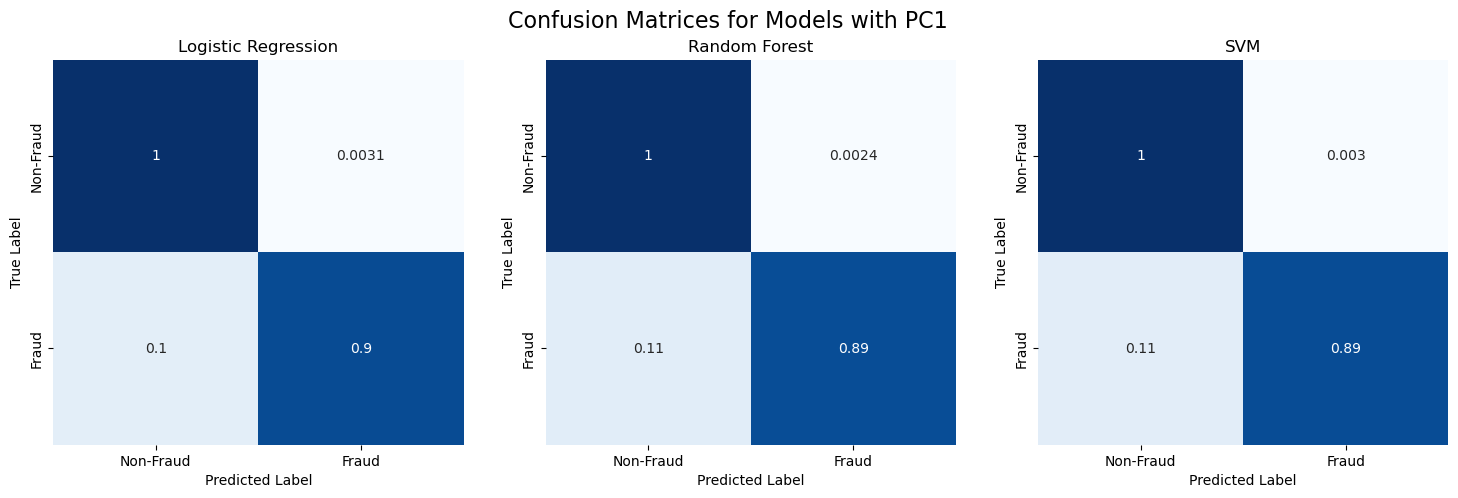

In [ ]:
logistic_regression = LogisticRegression(max_iter=1000)
random_forest = RandomForestClassifier(n_jobs=-1, random_state=42)
svm = SVC()

models = [logistic_regression, random_forest, svm]
model_names = ['Logistic Regression', 'Random Forest', 'SVM']
model_metrics = {}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices for Models with PC1', fontsize=16)
axes = axes.flatten()
for i, (model, name) in enumerate(zip(models, model_names)):
    model.fit(X_with_pca_train, y_train)
    y_pred = model.predict(X_with_pca_test)
    plot_confusion_matrix(y_test, y_pred, ax = axes[i])
    axes[i].set_title(name)
    p, r, f1, acc = evaluate_model(y_test, y_pred, print_report=False)
    model_metrics[name] = {'precision': p, 'recall': r, 'f1': f1, 'accuracy': acc}

In [ ]:
print("Metrics for models with PCA")
pd.DataFrame(model_metrics).T

Metrics for models with PCA


precision    recall        f1  accuracy
Logistic Regression   0.932280  0.895879  0.913717    0.9922
Random Forest         0.946636  0.885033  0.914798    0.9924
SVM                   0.934091  0.891540  0.912320    0.9921

In [ ]:
print("Difference in metrics with PCA features")
pd.DataFrame(model_metrics).T - with_engineered_metrics

Difference in metrics with PCA features


precision    recall        f1  accuracy
Logistic Regression  -0.011906  0.015184  0.002381    0.0001
Random Forest        -0.004527 -0.002169 -0.003271   -0.0003
SVM                   0.001658 -0.006508 -0.002597   -0.0002

It seems that all three models performance are slightly worse off in terms of most performance metrics. It is also worthwile to mention the dimensionality reduction benefits of making the model more computationally efficient. However, since our dataset was not very high-dimensional to begin with, it is best to omit PCA from our final model since the tradeoff is neglible in this case.

## 5.4 Improving our model: Hyperparameter Tuning

Let's use cross-validation to tune hyperparameters in our models to improve their performance. One specific parameter that we want to check across all three models is class_weight = 'balanced' to address class imbalance in our target variable. We will include additional hyperparameters to check as well. We will choose to optimize each model on f1-score to not emphasize precision or recall too heavily for the most balanced predictions.

In [ ]:
metrics_after_tuning = {model_name: {} for model_name in model_names}

### 5.4a Logistic Regresson


Precision: 0.94508
Recall: 0.89588
F1 Score: 0.91982
Accuracy: 0.99280
The best Logistic Regression has hyperparameters {'C': 100, 'class_weight': None}


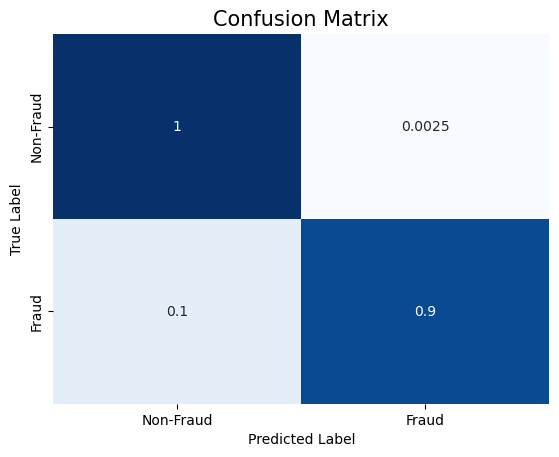

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 50, 100, 120, 200],  # Address regularization
    'class_weight': [None, 'balanced'],  # Address class imbalance
}

logistic_regression = GridSearchCV(estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
                                   param_grid=param_grid,
                                   cv=cv,
                                   scoring = 'f1',
                                   n_jobs=-1)

logistic_regression.fit(X_train_scaled, y_train)
y_pred = logistic_regression.predict(X_test_scaled)

plot_confusion_matrix(y_test, y_pred)
p, r, f1, acc = evaluate_model(y_test, y_pred)
metrics_after_tuning['Logistic Regression'] = {'precision': p, 'recall': r, 'f1': f1, 'accuracy': acc}
print(f'The best Logistic Regression has hyperparameters {logistic_regression.best_params_}')

### 5.4b Random Forest


For random forest, we will use randomize search with a wider range of hyperparameters. This is because random forest has many more hyperparameters to tune compared to logistic regression, and using a grid search with all possible combinations would be computationally expensive.

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

Precision: 0.95370
Recall: 0.89371
F1 Score: 0.92273
Accuracy: 0.99310
The best Random Forest model has hyperparameters {'class_weight': None, 'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 589}


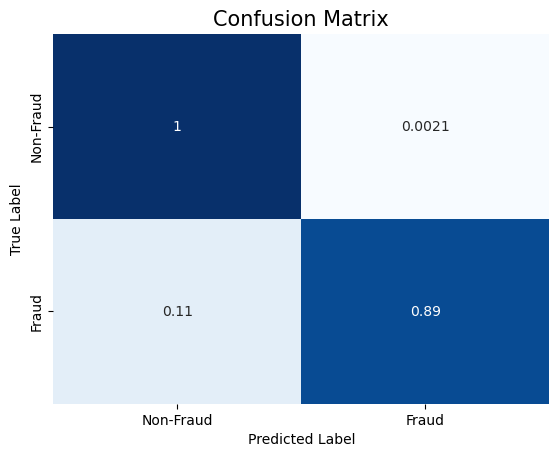

In [ ]:

param_distributions = {
    'class_weight': [None, 'balanced'],
    'n_estimators': randint(100, 1000),  # Randomly sample from 100 to 1000 trees
    'max_depth': randint(5, 50),  # Randomly sample max depth between 5 and 50
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples at a leaf node
}

rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42  #
)

rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

plot_confusion_matrix(y_test, y_pred_rf)
p, r, f1, acc = evaluate_model(y_test, y_pred_rf)
metrics_after_tuning.update({'Random Forest': {'precision': p, 'recall': r, 'f1': f1, 'accuracy': acc}})
print(f'The best Random Forest model has hyperparameters {rf.best_params_}')

### 5.4c SVM


Precision: 0.92650
Recall: 0.90239
F1 Score: 0.91429
Accuracy: 0.99220
The best SVM model has hyperparameters {'C': 100, 'class_weight': None, 'kernel': 'rbf'}


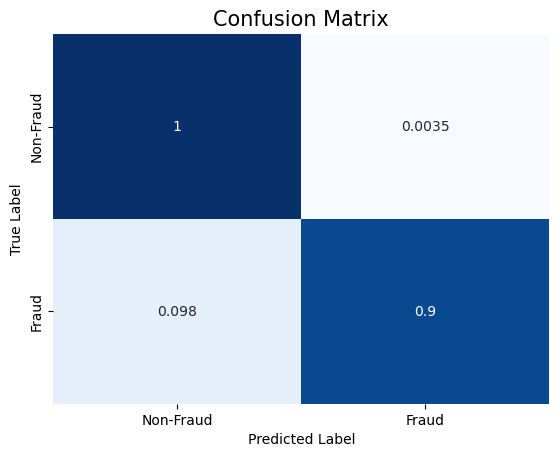

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 50, 100],  # Address regularization
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid' ],
    'class_weight': [None, 'balanced'],  # Address class imbalance
}

svm = GridSearchCV(estimator=SVC(random_state=42),
                  param_grid=param_grid,
                  cv=cv,
                  scoring='f1',
                  n_jobs=-1)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

plot_confusion_matrix(y_test, y_pred_svm)
p, r, f1, acc = evaluate_model(y_test, y_pred_svm)
metrics_after_tuning['SVM'] = {'precision': p, 'recall': r, 'f1': f1, 'accuracy': acc}

print(f'The best SVM model has hyperparameters {svm.best_params_}')

### 5.4d Comparison of tuned model performance to base model

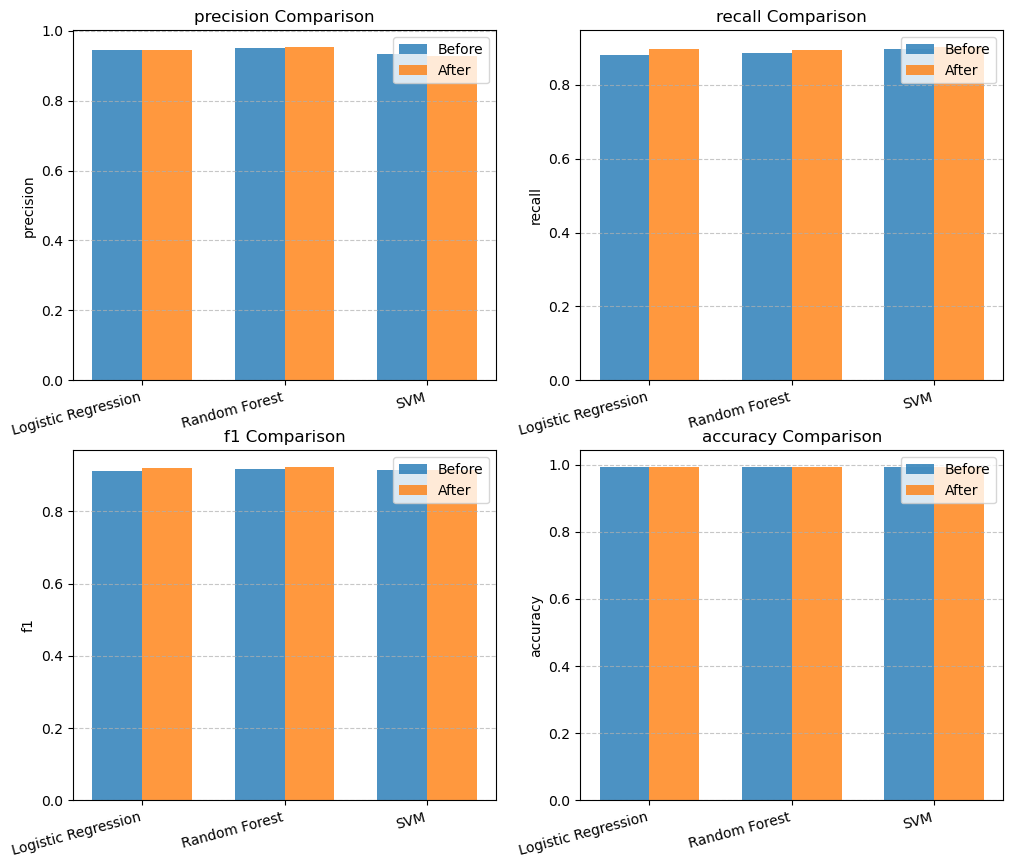

In [ ]:
metrics_after_tuning = pd.DataFrame(metrics_after_tuning).T
metrics = ['precision', 'recall', 'f1', 'accuracy']
x_labels = model_names

# Plot paired bar plots for each metric
x = np.arange(len(x_labels))  # Label locations
width = 0.35  # Width of the bars

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    ax.bar(x - width/2, with_engineered_metrics[metric], width, label='Before', alpha=0.8)
    ax.bar(x + width/2, metrics_after_tuning[metric], width, label='After', alpha=0.8)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=15, ha='right')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)


In [ ]:
(metrics_after_tuning - with_engineered_metrics)/with_engineered_metrics

precision    recall        f1  accuracy
Logistic Regression   0.000947  0.017241  0.009312  0.000706
Random Forest         0.002671  0.007335  0.005079  0.000403
SVM                  -0.006359  0.004831 -0.000690 -0.000101

## 5.5 Final Model and evaluation

Let's find out which model hast he highest f1 score

In [ ]:
metrics_after_tuning.sort_values(by='f1', ascending=False)

precision    recall        f1  accuracy
Random Forest         0.953704  0.893709  0.922732    0.9931
Logistic Regression   0.945080  0.895879  0.919822    0.9928
SVM                   0.926503  0.902386  0.914286    0.9922

Random Forest has the highest f1 score. Now, we train a Random Forest model with the best found hyperparameters, and evaluate its performance on the heldout set.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
best_rf_params = rf.best_params_
final_random_forest = RandomForestClassifier(**best_rf_params, random_state=42, n_jobs=-1)
final_random_forest.fit(X_scaled, y)

RandomForestClassifier(max_depth=39, min_samples_split=6, n_estimators=589,
                       n_jobs=-1, random_state=42)

In [ ]:
df_test = pd.read_csv("data/heldout_data.csv")
X_heldout = df_test.drop(columns='fraud')
y_heldout = df_test['fraud']

X_heldout['totalItems'] = (X_heldout['scannedLineItemsPerSecond'] * X_heldout['totalScanTimeInSeconds']).astype(int)
X_heldout_scaled = scaler.transform(X_heldout)
X_heldout_scaled = pd.DataFrame(X_heldout_scaled, columns=X_heldout.columns)

Precision: 0.93715
Recall: 0.90307
F1 Score: 0.91979
Accuracy: 0.99248


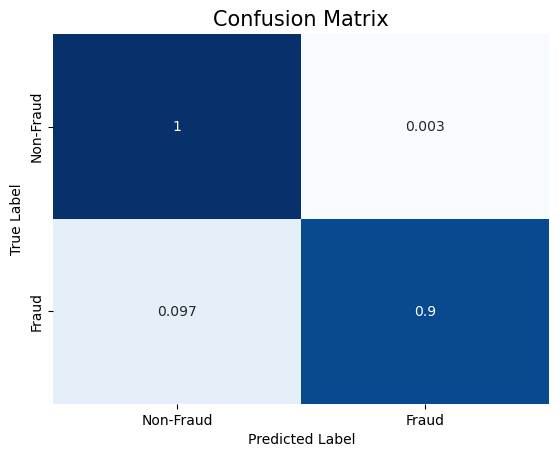

In [ ]:
y_pred_heldout = final_random_forest.predict(X_heldout_scaled)
plot_confusion_matrix(y_heldout, y_pred_heldout)
evaluate_model(y_heldout, y_pred_heldout);

## 5.6 Interpreting the model

To visalize the feature importances, we can plot a horizontal bar plot of the feature importances. We sort the features by their importance to make it easier to read.

Text(0, 0.5, 'Importance')

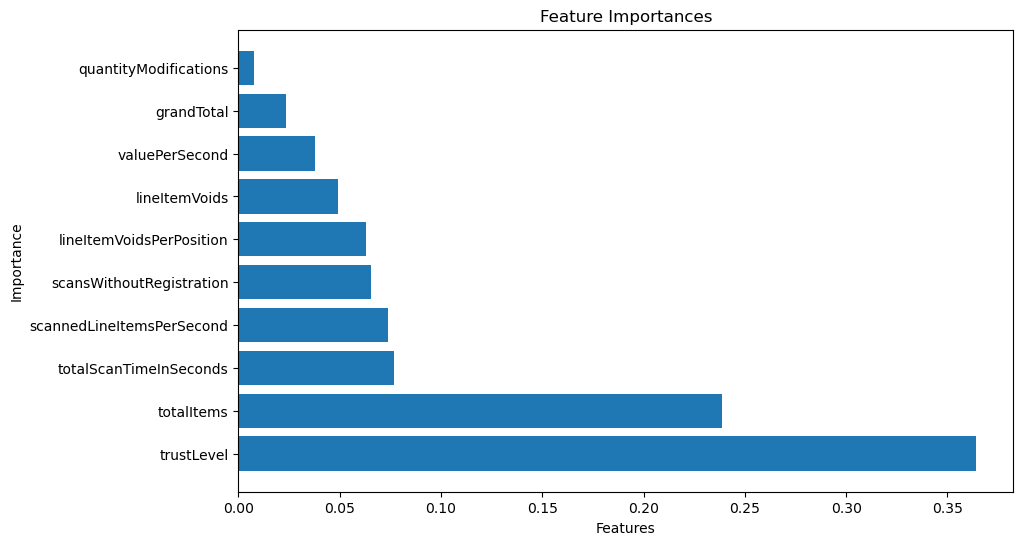

In [ ]:
# plot feature importances
importances = final_random_forest.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(X.columns[indices], importances[indices])
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')


1.	Top Important Features:
	- trustLevel: The most influential feature, with an importance of just under 0.35. This suggests a strong correlation between the trust level and the target variable, making it crucial for the model’s predictions.
	- totalItems: Following closely, this feature also holds substantial weight in the model, indicating its strong predictive power regarding the outcome.
2.	Moderately Important Features:
	- totalScanTimeInSeconds and scannedLineItemsPerSecond: These features have a moderate impact, each contributing significantly but less so than the top features.
3.	Less Important Features:
	- Features like scansWithoutRegistration, lineItemVoidsPerPosition, and lineItemVoids show lesser importance, suggesting that while they contribute to model decisions, they have a smaller effect compared to others.
	- valuePerSecond and grandTotal: These features, although somewhat impactful, are among the least significant in terms of driving the model’s predictions.
4.	Least Important Features:
	- quantityModifications: This feature has the least importance, which could indicate its minimal utility in improving model accuracy or that it is possibly redundant given other features.

# Part 6: Implications and Insights

The features `totalItems`, `totalScanTimeInSeconds`, `lineItemVoids`, and `scansWithoutRegistration` are all strong, statistically significant indicators of whether or not a transaction is fraudulent. Feature engineering was also important since some raw features, such as `scannedLineItemsPerSecond`, were skewed and not directly helpful for detecting fraudulent transactions. Feature engineering helped create more informative attributes, like `totalItems`, which significantly improved all baseline models.

These findings have major implications for stakeholders like businesses. Fraudulent transactions tend to feature a greater total number of items scanned, longer total scan time, more voided items, and more frequent attempts to activate the scanner without actually scanning anything. The ability to identify fraudulent transactions helps businesses avoid monetary loss and minimize shrinkage.

Our final model decision came down to maximizing F1 score, taking a balanced approached to mitigating both false positives and false negatives. False negatives would be flagging customers for fraudulent checkouts; when in reality, they did not commit fraud. Too many of these cases could lead to customer dissatisfaction with shopping at this store. False negatives would be failing to classify fraudulent checkouts, leading to financial losses for the company. Both scenarios would negatively impact companies with self-checkouts in different ways.

# Part 7: Challenges / Limitations / Future Work

Our analysis faced several challenges and limitations. The dataset contained strong class imbalance, with less than 5% of the data being fraudulent. Features such as `scannedLineItemsPerSecond` were misleading due to anomalies like batch processing, thus necessitating the use of feature engineering. Features like `trustLevel` were calculated from unknown models, making it hard to generalize findings to different settings. Furthermore, some features were highly correlated, increasing the risk of multicollinearity in our modeling. While PCA was tested to address this, it worsened our models' performance in most metrics. Thus, a trade-off was made to omit PCA from our final model.

Future work may entail further investigation into how `trustLevel` is calculated. This is beneficial as it gives deeper insight into what makes a transaction more likely to be fraud. If there are underlying biases in `trustLevel` on race or gender, this could lead to customer dissatisfaction or even worse, scandals in the media. Furthermore, collecting data about the types of products in the transactions may further improve model performances. Having this data can also help prevent frauds. For example, if a lot of the fraudulent transactions include socks, stores can put security tags on socks.